In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt # Optional for plotting fits

# --- Constants ---
G = 6.67430e-11
M_SUN = 1.989e30
KPC_TO_M = 3.0857e19
C = 2.99792458e8
# Lambda coupling constant from vFinal Appendix A.2.6 [cite: 56]
# lambda_coupling_alt = c**2 * L_p**2 / (4 * np.pi * G) # Formula from [cite: 56]
# L_p = 1.616255e-35
# lambda_coupling = C**2 * L_p**2 / (4 * np.pi * G) # ~2.75e-28 m^2
# Use the value stated in the text directly:
lambda_coupling = 2.75e-28 # m^2

# --- Galaxy Data Provided by User ---
galaxy_data_input = [
    {
        "name": "Milky Way",
        "M_bulge_solar": 1.0e10, "M_disk_solar": 5.0e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.5,
        "radii_kpc": [2, 5, 8, 12, 20],
        "v_obs": [216.5, 230, 228, 220, 215], # Corrected observed values if intended
        "v_err": [28, 15, 10, 20, 25] # Errors corresponding to v_obs list
    },
    {
        "name": "NGC 2403",
        "M_bulge_solar": 0.2e10, "M_disk_solar": 1.3e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.0,
        "radii_kpc": [2, 6, 10],
        "v_obs": [140, 140, 140],
        "v_err": [10, 10, 10]
    },
    {
        "name": "UGC 128",
        "M_bulge_solar": 0.1e10, "M_disk_solar": 0.9e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.5,
        "radii_kpc": [2, 6, 10],
        "v_obs": [120, 120, 120],
        "v_err": [10, 10, 10]
    },
    {
        "name": "Andromeda (M31)",
        "M_bulge_solar": 2.0e10, "M_disk_solar": 5.7e10,
        "r_bulge_kpc": 2.0, "r_disk_kpc": 5.5,
        "radii_kpc": [5, 12, 20],
        "v_obs": [250, 250, 250],
        "v_err": [20, 20, 20] # Assumed errors
    },
    {
        "name": "NGC 3198",
        "M_bulge_solar": 0.3e10, "M_disk_solar": 1.4e10,
        "r_bulge_kpc": 1.2, "r_disk_kpc": 4.0,
        "radii_kpc": [5, 10, 15],
        "v_obs": [145, 145, 145],
        "v_err": [10, 10, 10] # Assumed errors
    }
]

# --- Functions ---

def M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc):
    """Calculates enclosed baryonic mass (kg) at radius r (kpc)."""
    r_kpc_float = float(r_kpc)
    if r_kpc_float <= 0: return 0.0
    M_bulge_kg = M_bulge_solar * M_SUN * (r_kpc_float / r_bulge_kpc) / (1 + r_kpc_float / r_bulge_kpc)
    # Corrected cumulative exponential disk mass
    M_disk_kg = M_disk_solar * M_SUN * (1 - (1 + r_kpc_float / r_disk_kpc) * np.exp(-r_kpc_float / r_disk_kpc))
    return M_bulge_kg + M_disk_kg

def M_ent_log_profile(r_m, S0, rs_m):
    """Calculates entropic mass from logarithmic profile."""
    # Formula from Appendix A.2.2 integration[cite: 500], adjusted
    # Ment(r) = (lambda * S0 / G) * [ ln(1 + r/rs) - r/(r+rs) ]
    if r_m <= 0 or rs_m <= 0 or S0 <= 0: # Parameters must be positive
         return 0.0
    ratio = r_m / rs_m
    # Prevent log(1) issues or division by zero if r or rs is zero
    term1 = np.log(1 + ratio)
    term2 = ratio / (1 + ratio)
    # Check for NaN which can occur if ratio is large causing overflow/precision issues
    if np.isnan(term1) or np.isnan(term2):
        return np.inf # Or handle large values appropriately
    mass = (lambda_coupling * S0 / G) * (term1 - term2)
    # Mass must be non-negative
    return max(0.0, mass)


def v_rot_log_profile(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, S0, rs_kpc):
    """Calculates rotation velocity using M_ent from log profile."""
    r_m = r_kpc * KPC_TO_M
    rs_m = rs_kpc * KPC_TO_M
    if r_m <= 0: return 0

    enclosed_baryonic_mass = M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc)
    entropic_mass = M_ent_log_profile(r_m, S0, rs_m)

    effective_mass = enclosed_baryonic_mass + entropic_mass
    if effective_mass <= 0: return 0

    return np.sqrt(G * effective_mass / r_m) / 1000 # Return km/s

# --- Fitting Function ---
# We need a wrapper function for curve_fit
def fit_wrapper(r_kpc_array, log10_S0, log10_rs_kpc, # Fit log of parameters for stability
                M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc):
    S0 = 10**log10_S0
    rs_kpc = 10**log10_rs_kpc
    velocities = [v_rot_log_profile(r, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, S0, rs_kpc)
                  for r in r_kpc_array]
    return np.array(velocities)

# --- Perform Fitting and Print Results ---

print("--- Galaxy Rotation Curve Test using M_ent from Logarithmic S_ent Profile ---")
print("(Fitting S0 and rs for each galaxy)")

results_summary = []

for galaxy in galaxy_data_input:
    name = galaxy["name"]
    M_bulge = galaxy["M_bulge_solar"]
    M_disk = galaxy["M_disk_solar"]
    r_bulge = galaxy["r_bulge_kpc"]
    r_disk = galaxy["r_disk_kpc"]
    radii_obs = np.array(galaxy["radii_kpc"])
    v_obs = np.array(galaxy["v_obs"])
    v_err_obs = np.array(galaxy["v_err"])

    print(f"\n=== Fitting {name} ===")

    # Define the function to fit with fixed galaxy parameters
    func_to_fit = lambda r, logS0, logRs: fit_wrapper(r, logS0, logRs, M_bulge, M_disk, r_bulge, r_disk)

    # Initial guesses (log10 space) - Might need tuning per galaxy!
    # S0 ~ 1e58 - 1e61 (from previous paper discussions) -> log10(S0) ~ 58-61
    # rs ~ 1 - 10 kpc (typical galaxy scales) -> log10(rs) ~ 0-1
    initial_guess = [60, 0.5] # log10(S0), log10(rs_kpc)
    # Bounds to keep parameters physical (S0 > 0, rs > 0)
    lower_bounds = [50, -1] # log10(S0) > 50, log10(rs_kpc) > -1 (rs > 0.1 kpc)
    upper_bounds = [65, 2]  # log10(S0) < 65, log10(rs_kpc) < 2 (rs < 100 kpc)

    try:
        # Perform the fit using observed velocities and errors (sigma)
        popt, pcov = curve_fit(
            func_to_fit,
            radii_obs,
            v_obs,
            p0=initial_guess,
            sigma=v_err_obs, # Use errors for weighted fit
            absolute_sigma=True,
            bounds=(lower_bounds, upper_bounds),
            maxfev=5000 # Increase max iterations if needed
        )

        # Extract best-fit parameters
        log_S0_fit, log_rs_kpc_fit = popt
        S0_fit = 10**log_S0_fit
        rs_kpc_fit = 10**log_rs_kpc_fit
        # Calculate uncertainties (optional)
        perr = np.sqrt(np.diag(pcov))
        log_S0_err, log_rs_err = perr
        # Propagate errors approximately (careful with log)
        S0_err = S0_fit * np.log(10) * log_S0_err if S0_fit > 0 else np.nan
        rs_err = rs_kpc_fit * np.log(10) * log_rs_err if rs_kpc_fit > 0 else np.nan


        print(f"Best Fit Parameters:")
        print(f"  log10(S0) = {log_S0_fit:.2f} +/- {log_S0_err:.2f} => S0 = {S0_fit:.2e} +/- {S0_err:.1e} bits (?)")
        print(f"  log10(rs) = {log_rs_kpc_fit:.2f} +/- {log_rs_err:.2f} => rs = {rs_kpc_fit:.2f} +/- {rs_err:.2f} kpc")
        print("-" * 65)
        print("Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%) | Within Error?")
        print("-" * 65)

        v_pred_list_fit = []
        for i, r in enumerate(radii_obs):
            v_p = v_rot_log_profile(r, M_bulge, M_disk, r_bulge, r_disk, S0_fit, rs_kpc_fit)
            v_o = v_obs[i]
            v_e = v_err_obs[i]
            v_pred_list_fit.append(v_p)

            diff_str = "---"
            within_err_str = "---"
            if v_o is not None and v_o > 0:
                diff_percent = ((v_p - v_o) / v_o) * 100
                diff_str = f"{diff_percent:+.1f}%"
                within_err = abs(v_p - v_o) <= v_e
                within_err_str = "Yes" if within_err else "No"
            elif v_o is None:
                 diff_str = "N/A"

            print(f"{r:>12.1f} | {v_p:>18.1f} | {v_o if v_o is not None else 'N/A':>17} | {diff_str:>10} | {within_err_str:>12}")

        results_summary.append({
            "Galaxy": name,
            "S0_fit": S0_fit,
            "rs_kpc_fit": rs_kpc_fit,
            "Fit_Success": True
        })

        # Optional Plotting
        # plt.figure(figsize=(8, 5))
        # radii_smooth = np.linspace(min(0.1, np.min(radii_obs[radii_obs>0])), np.max(radii_obs), 100)
        # v_model_smooth = [v_rot_log_profile(r, M_bulge, M_disk, r_bulge, r_disk, S0_fit, rs_kpc_fit) for r in radii_smooth]
        # plt.errorbar(radii_obs, v_obs, yerr=v_err_obs, fmt='ro', capsize=4, label="Observed")
        # plt.plot(radii_smooth, v_model_smooth, 'b-', linewidth=2, label=f"Predicted (S0={S0_fit:.1e}, rs={rs_kpc_fit:.1f})")
        # plt.title(f"{name} Rotation Curve (Log Profile Fit)")
        # plt.xlabel("Radius (kpc)")
        # plt.ylabel("Velocity (km/s)")
        # plt.grid(True)
        # plt.legend()
        # plt.show()


    except RuntimeError:
        print("Error: curve_fit failed to converge. Try adjusting initial guesses or bounds.")
        results_summary.append({
            "Galaxy": name,
            "S0_fit": np.nan,
            "rs_kpc_fit": np.nan,
            "Fit_Success": False
        })
    except Exception as e:
        print(f"An unexpected error occurred during fitting: {e}")
        results_summary.append({
            "Galaxy": name,
            "S0_fit": np.nan,
            "rs_kpc_fit": np.nan,
            "Fit_Success": False
        })

    print("-" * 65)

print("\n--- Fitting Complete ---")

# Optional: Display summary of fits
# try:
#     df_fit_summary = pd.DataFrame(results_summary)
#     print("\nFit Summary:")
#     print(df_fit_summary.to_string())
# except ImportError:
#     print("\n(Pandas library not found, skipping DataFrame summary)")
# except Exception as e:
#     print(f"\nError creating DataFrame: {e}")

--- Galaxy Rotation Curve Test using M_ent from Logarithmic S_ent Profile ---
(Fitting S0 and rs for each galaxy)

=== Fitting Milky Way ===
Best Fit Parameters:
  log10(S0) = 58.91 +/- 0.32 => S0 = 8.09e+58 +/- 6.0e+58 bits (?)
  log10(rs) = 0.70 +/- 0.29 => rs = 5.00 +/- 3.31 kpc
-----------------------------------------------------------------
Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%) | Within Error?
-----------------------------------------------------------------
         2.0 |              206.6 |             216.5 |      -4.6% |          Yes
         5.0 |              229.0 |             230.0 |      -0.4% |          Yes
         8.0 |              230.4 |             228.0 |      +1.0% |          Yes
        12.0 |              222.8 |             220.0 |      +1.3% |          Yes
        20.0 |              204.2 |             215.0 |      -5.0% |          Yes
-----------------------------------------------------------------

=== Fitting NGC 2403 ===
Be

In [ ]:
import numpy as np
import pandas as pd # Optional for displaying summary table
from scipy.optimize import curve_fit

# --- Constants ---
G = 6.67430e-11
M_SUN = 1.989e30
KPC_TO_M = 3.0857e19
C = 2.99792458e8
# Lambda coupling constant from vFinal text
lambda_coupling = 2.75e-28 # m^2

# --- Galaxy Data (Combined from User Input) ---
# Using dictionary format for easier parameter access
galaxy_data_input = {
    "Milky Way": {
        "M_bulge_solar": 1.0e10, "M_disk_solar": 5.0e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 5, 8, 12, 20]),
        "v_obs": np.array([216.5, 230, 228, 220, 215]),
        "v_err": np.array([28, 15, 10, 20, 25])
    },
    "NGC 2403": {
        "M_bulge_solar": 0.2e10, "M_disk_solar": 1.3e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.0,
        "radii_kpc": np.array([2, 6, 10]),
        "v_obs": np.array([140, 140, 140]),
        "v_err": np.array([10, 10, 10])
    },
    "UGC 128": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 0.9e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 6, 10]),
        "v_obs": np.array([120, 120, 120]),
        "v_err": np.array([10, 10, 10])
    },
    "Andromeda (M31)": {
        "M_bulge_solar": 2.0e10, "M_disk_solar": 5.7e10,
        "r_bulge_kpc": 2.0, "r_disk_kpc": 5.5,
        "radii_kpc": np.array([5, 12, 20]),
        "v_obs": np.array([250, 250, 250]),
        "v_err": np.array([20, 20, 20]) # Assumed errors previously
    },
    "NGC 3198": {
        "M_bulge_solar": 0.3e10, "M_disk_solar": 1.4e10,
        "r_bulge_kpc": 1.2, "r_disk_kpc": 4.0,
        "radii_kpc": np.array([5, 10, 15]),
        "v_obs": np.array([145, 145, 145]),
        "v_err": np.array([10, 10, 10]) # Assumed errors previously
    },
     "NGC 7331": {
        "M_bulge_solar": 3.0e10, "M_disk_solar": 6.0e10,
        "r_bulge_kpc": 2.0, "r_disk_kpc": 4.0,
        "radii_kpc": np.array([3, 6, 9, 12, 18]),
        "v_obs": np.array([180, 210, 225, 230, 230]),
        "v_err": np.array([15]*5)
    },
    "NGC 5055": {
        "M_bulge_solar": 1.2e10, "M_disk_solar": 4.3e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 5, 8, 12, 20]),
        "v_obs": np.array([160, 185, 200, 205, 205]),
        "v_err": np.array([12]*5)
    },
    "NGC 6946": {
        "M_bulge_solar": 0.8e10, "M_disk_solar": 2.7e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 2.8,
        "radii_kpc": np.array([1, 4, 8, 12]),
        "v_obs": np.array([90, 135, 155, 160]),
        "v_err": np.array([10]*4)
    },
    "NGC 2903": {
        "M_bulge_solar": 1.5e10, "M_disk_solar": 3.0e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.0,
        "radii_kpc": np.array([2, 5, 10, 15]),
        "v_obs": np.array([130, 170, 190, 190]),
        "v_err": np.array([12]*4)
    },
    "NGC 3621": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 2.0e10,
        "r_bulge_kpc": 0.8, "r_disk_kpc": 2.5,
        "radii_kpc": np.array([1, 3, 6, 10]),
        "v_obs": np.array([75, 110, 125, 130]), # Completed data
        "v_err": np.array([8]*4) # Completed data
    },
    "NGC 2841": {
        # Using the data from the new list, replacing any older entry implicitly
        "M_bulge_solar": 2.5e10, "M_disk_solar": 4.5e10,
        "r_bulge_kpc": 1.8, "r_disk_kpc": 3.8,
        "radii_kpc": np.array([2, 6, 10, 16]),
        "v_obs": np.array([180, 215, 225, 230]), # Completed data
        "v_err": np.array([15]*4) # Completed data
    },
    "NGC 3521": {
        "M_bulge_solar": 1.6e10, "M_disk_solar": 3.6e10,
        "r_bulge_kpc": 1.6, "r_disk_kpc": 3.2,
        "radii_kpc": np.array([2, 6, 10, 14]),
        "v_obs": np.array([145, 175, 185, 190]), # Completed data
        "v_err": np.array([12]*4) # Completed data
    },
    "NGC 925": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 1.3e10, # M_disk corrected based on likely context
        "r_bulge_kpc": 0.7, "r_disk_kpc": 2.2,
        "radii_kpc": np.array([1, 3, 6, 9]),
        "v_obs": np.array([65, 90, 100, 105]), # Completed data
        "v_err": np.array([7]*4) # Completed data
    }
    # Add DDO154 back if needed, was in previous sigmoid test but not new list
    # "DDO154": { ... }
}


# --- Functions ---

def M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc):
    """Calculates enclosed baryonic mass (kg) at radius r (kpc)."""
    r_kpc_float = float(r_kpc)
    if r_kpc_float <= 0: return 0.0
    # Using simple Hernquist bulge cumulative mass approx
    M_bulge_kg = M_bulge_solar * M_SUN * (r_kpc_float / r_bulge_kpc) / (1 + r_kpc_float / r_bulge_kpc)
    # Corrected cumulative exponential disk mass
    M_disk_kg = M_disk_solar * M_SUN * (1 - (1 + r_kpc_float / r_disk_kpc) * np.exp(-r_kpc_float / r_disk_kpc))
    return M_bulge_kg + M_disk_kg

# From
def M_ent_log_profile(r_m, S0, rs_m):
    """Calculates entropic mass from logarithmic profile."""
    if r_m <= 0 or rs_m <= 0 or S0 <= 0: return 0.0
    ratio = r_m / rs_m
    # Use np.log1p for better precision for small ratio -> log(1+ratio)
    term1 = np.log1p(ratio)
    term2 = ratio / (1 + ratio)
    if np.isnan(term1) or np.isnan(term2): return np.inf # Handle potential issues
    mass = (lambda_coupling * S0 / G) * (term1 - term2)
    return max(0.0, mass) # Ensure non-negative mass

# Velocity function using M_ent from log profile
def v_rot_log_profile(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, S0, rs_kpc):
    """Calculates rotation velocity using M_ent from log profile."""
    r_m = r_kpc * KPC_TO_M
    rs_m = rs_kpc * KPC_TO_M
    if r_m <= 0: return 0

    enclosed_baryonic_mass = M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc)
    entropic_mass = M_ent_log_profile(r_m, S0, rs_m)
    effective_mass = enclosed_baryonic_mass + entropic_mass
    if effective_mass <= 0: return 0

    return np.sqrt(G * effective_mass / r_m) / 1000 # Return km/s

# --- Fitting Function ---
def fit_wrapper(r_kpc_array, log10_S0, log10_rs_kpc, # Fit log of parameters
                M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc):
    """Wrapper for curve_fit."""
    # Convert log parameters back to linear scale
    S0 = 10**log10_S0
    rs_kpc = 10**log10_rs_kpc
    # Calculate velocities for all radii in the input array
    velocities = [v_rot_log_profile(r, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, S0, rs_kpc)
                  for r in r_kpc_array]
    return np.array(velocities)

# --- Perform Fitting and Print Results ---

print("--- Galaxy Rotation Curve Test using M_ent from Logarithmic S_ent Profile ---")
print("(Fitting S0 and rs for each galaxy)")

results_summary = []

for name, galaxy in galaxy_data_input.items(): # Iterate through dictionary
    M_bulge = galaxy["M_bulge_solar"]
    M_disk = galaxy["M_disk_solar"]
    r_bulge = galaxy["r_bulge_kpc"]
    r_disk = galaxy["r_disk_kpc"]
    radii_obs = galaxy["radii_kpc"] # Already numpy arrays
    v_obs = galaxy["v_obs"]         # Already numpy arrays
    v_err_obs = galaxy["v_err"]     # Already numpy arrays

    print(f"\n=== Fitting {name} ===")

    # Define the function to fit with fixed galaxy parameters for this iteration
    func_to_fit = lambda r, logS0, logRs: fit_wrapper(r, logS0, logRs, M_bulge, M_disk, r_bulge, r_disk)

    # Initial guesses and bounds (log10 space) - might need tuning
    initial_guess = [60, 0.5] # log10(S0), log10(rs_kpc)
    lower_bounds = [55, -1]   # S0 > 1e55, rs > 0.1 kpc
    upper_bounds = [65, 2]    # S0 < 1e65, rs < 100 kpc

    try:
        popt, pcov = curve_fit(
            func_to_fit,
            radii_obs,
            v_obs,
            p0=initial_guess,
            sigma=v_err_obs,
            absolute_sigma=True,
            bounds=(lower_bounds, upper_bounds),
            maxfev=8000 # Increased iterations
        )

        log_S0_fit, log_rs_kpc_fit = popt
        S0_fit = 10**log_S0_fit
        rs_kpc_fit = 10**log_rs_kpc_fit
        perr = np.sqrt(np.diag(pcov))
        log_S0_err, log_rs_err = perr
        # Propagate errors approximately (use relative error for log)
        S0_err_rel = perr[0] * np.log(10) # Relative error from log
        rs_err_rel = perr[1] * np.log(10) # Relative error from log
        S0_err_abs = S0_fit * S0_err_rel if S0_fit > 0 else np.nan
        rs_err_abs = rs_kpc_fit * rs_err_rel if rs_kpc_fit > 0 else np.nan


        print(f"Best Fit Parameters:")
        print(f"  log10(S0) = {log_S0_fit:.2f} +/- {log_S0_err:.2f} => S0 = {S0_fit:.2e} +/- {S0_err_abs:.1e} bits (?)")
        print(f"  log10(rs) = {log_rs_kpc_fit:.2f} +/- {log_rs_err:.2f} => rs = {rs_kpc_fit:.2f} +/- {rs_err_abs:.2f} kpc")
        print("-" * 65)
        print("Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%) | Within Error?")
        print("-" * 65)

        v_pred_list_fit = []
        for i, r in enumerate(radii_obs):
            v_p = v_rot_log_profile(r, M_bulge, M_disk, r_bulge, r_disk, S0_fit, rs_kpc_fit)
            v_o = v_obs[i]
            v_e = v_err_obs[i]
            v_pred_list_fit.append(v_p)

            diff_str = "---"
            within_err_str = "---"
            if v_o is not None and v_o > 0:
                diff_percent = ((v_p - v_o) / v_o) * 100
                diff_str = f"{diff_percent:+.1f}%"
                within_err = abs(v_p - v_o) <= v_e
                within_err_str = "Yes" if within_err else "No"
            elif v_o is None:
                 diff_str = "N/A"

            print(f"{r:>12.1f} | {v_p:>18.1f} | {v_o if v_o is not None else 'N/A':>17} | {diff_str:>10} | {within_err_str:>12}")

        results_summary.append({
            "Galaxy": name,
            "S0_fit": S0_fit,
            "rs_kpc_fit": rs_kpc_fit,
            "Fit_Success": True
        })

    except RuntimeError:
        print("Error: curve_fit failed to converge. Try adjusting initial guesses or bounds.")
        results_summary.append({
            "Galaxy": name,
            "S0_fit": np.nan,
            "rs_kpc_fit": np.nan,
            "Fit_Success": False
        })
    except Exception as e:
        print(f"An unexpected error occurred during fitting for {name}: {e}")
        results_summary.append({
            "Galaxy": name,
            "S0_fit": np.nan,
            "rs_kpc_fit": np.nan,
            "Fit_Success": False
        })

    print("-" * 65)

print("\n--- Fitting Complete ---")

# Optional: Display summary of fits
try:
    df_fit_summary = pd.DataFrame(results_summary)
    print("\nFit Summary:")
    print(df_fit_summary.to_string())
except ImportError:
    print("\n(Pandas library not found, skipping DataFrame summary)")
except Exception as e:
    print(f"\nError creating DataFrame: {e}")

--- Galaxy Rotation Curve Test using M_ent from Logarithmic S_ent Profile ---
(Fitting S0 and rs for each galaxy)

=== Fitting Milky Way ===
Best Fit Parameters:
  log10(S0) = 58.91 +/- 0.32 => S0 = 8.09e+58 +/- 6.0e+58 bits (?)
  log10(rs) = 0.70 +/- 0.29 => rs = 5.00 +/- 3.31 kpc
-----------------------------------------------------------------
Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%) | Within Error?
-----------------------------------------------------------------
         2.0 |              206.6 |             216.5 |      -4.6% |          Yes
         5.0 |              229.0 |             230.0 |      -0.4% |          Yes
         8.0 |              230.4 |             228.0 |      +1.0% |          Yes
        12.0 |              222.8 |             220.0 |      +1.3% |          Yes
        20.0 |              204.2 |             215.0 |      -5.0% |          Yes
-----------------------------------------------------------------

=== Fitting NGC 2403 ===
Be

In [ ]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt # Keep commented out for text output

# --- Constants ---
G = 6.67430e-11
M_SUN = 1.989e30
KPC_TO_M = 3.0857e19

# --- Galaxy Data (Combined from User Input) ---
galaxy_data_input = {
    "Milky Way": {
        "M_bulge_solar": 1.0e10, "M_disk_solar": 5.0e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 5, 8, 12, 20]),
        "v_obs": np.array([216.5, 230, 228, 220, 215]),
        "v_err": np.array([28, 15, 10, 20, 25])
    },
    "NGC 2403": {
        "M_bulge_solar": 0.2e10, "M_disk_solar": 1.3e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.0,
        "radii_kpc": np.array([2, 6, 10]),
        "v_obs": np.array([140, 140, 140]),
        "v_err": np.array([10, 10, 10])
    },
    "UGC 128": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 0.9e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 6, 10]),
        "v_obs": np.array([120, 120, 120]),
        "v_err": np.array([10, 10, 10])
    },
    "Andromeda (M31)": {
        "M_bulge_solar": 2.0e10, "M_disk_solar": 5.7e10,
        "r_bulge_kpc": 2.0, "r_disk_kpc": 5.5,
        "radii_kpc": np.array([5, 12, 20]),
        "v_obs": np.array([250, 250, 250]),
        "v_err": np.array([20, 20, 20])
    },
    "NGC 3198": {
        "M_bulge_solar": 0.3e10, "M_disk_solar": 1.4e10,
        "r_bulge_kpc": 1.2, "r_disk_kpc": 4.0,
        "radii_kpc": np.array([5, 10, 15]),
        "v_obs": np.array([145, 145, 145]),
        "v_err": np.array([10, 10, 10])
    },
     "NGC 7331": {
        "M_bulge_solar": 3.0e10, "M_disk_solar": 6.0e10,
        "r_bulge_kpc": 2.0, "r_disk_kpc": 4.0,
        "radii_kpc": np.array([3, 6, 9, 12, 18]),
        "v_obs": np.array([180, 210, 225, 230, 230]),
        "v_err": np.array([15]*5)
    },
    "NGC 5055": {
        "M_bulge_solar": 1.2e10, "M_disk_solar": 4.3e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.5,
        "radii_kpc": np.array([2, 5, 8, 12, 20]),
        "v_obs": np.array([160, 185, 200, 205, 205]),
        "v_err": np.array([12]*5)
    },
    "NGC 6946": {
        "M_bulge_solar": 0.8e10, "M_disk_solar": 2.7e10,
        "r_bulge_kpc": 1.0, "r_disk_kpc": 2.8,
        "radii_kpc": np.array([1, 4, 8, 12]),
        "v_obs": np.array([90, 135, 155, 160]),
        "v_err": np.array([10]*4)
    },
    "NGC 2903": {
        "M_bulge_solar": 1.5e10, "M_disk_solar": 3.0e10,
        "r_bulge_kpc": 1.5, "r_disk_kpc": 3.0,
        "radii_kpc": np.array([2, 5, 10, 15]),
        "v_obs": np.array([130, 170, 190, 190]),
        "v_err": np.array([12]*4)
    },
    "NGC 3621": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 2.0e10,
        "r_bulge_kpc": 0.8, "r_disk_kpc": 2.5,
        "radii_kpc": np.array([1, 3, 6, 10]),
        "v_obs": np.array([75, 110, 125, 130]),
        "v_err": np.array([8]*4)
    },
    "NGC 2841": {
        "M_bulge_solar": 2.5e10, "M_disk_solar": 4.5e10,
        "r_bulge_kpc": 1.8, "r_disk_kpc": 3.8,
        "radii_kpc": np.array([2, 6, 10, 16]),
        "v_obs": np.array([180, 215, 225, 230]),
        "v_err": np.array([15]*4)
    },
    "NGC 3521": {
        "M_bulge_solar": 1.6e10, "M_disk_solar": 3.6e10,
        "r_bulge_kpc": 1.6, "r_disk_kpc": 3.2,
        "radii_kpc": np.array([2, 6, 10, 14]),
        "v_obs": np.array([145, 175, 185, 190]),
        "v_err": np.array([12]*4)
    },
    "NGC 925": {
        "M_bulge_solar": 0.1e10, "M_disk_solar": 1.3e10,
        "r_bulge_kpc": 0.7, "r_disk_kpc": 2.2,
        "radii_kpc": np.array([1, 3, 6, 9]),
        "v_obs": np.array([65, 90, 100, 105]),
        "v_err": np.array([7]*4)
    }
}

# --- Functions ---

def M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc):
    """Calculates enclosed baryonic mass (kg) at radius r (kpc)."""
    r_kpc_float = float(r_kpc)
    if r_kpc_float <= 0: return 0.0
    M_bulge_kg = M_bulge_solar * M_SUN * (r_kpc_float / r_bulge_kpc) / (1 + r_kpc_float / r_bulge_kpc)
    M_disk_kg = M_disk_solar * M_SUN * (1 - (1 + r_kpc_float / r_disk_kpc) * np.exp(-r_kpc_float / r_disk_kpc)) # Cumulative exponential
    return M_bulge_kg + M_disk_kg

# Broken power law for k' (kg/m) - from velocity v6_.docx
def k_prime_predictive(M_b_total_kg):
    """Calculates k' using the predictive broken power law based on TOTAL M_b."""
    if M_b_total_kg <= 0: return 0.0
    log_M = np.log10(M_b_total_kg)
    M_break_kg = 6.44e40
    log_break = np.log10(M_break_kg)
    alpha1 = 0.69
    alpha2 = 1.55

    if log_M < log_break:
        k_prime = 1.61e20 * (M_b_total_kg / M_break_kg)**alpha1
    else:
        # Use the coefficient for the high-mass regime, maintaining continuity approx.
        # The fit suggests k' at break is ~10^20.57, let's use that for continuity
        log_kp_break = 20.57 # From empirical fit log value in v6_.docx code
        k_prime = 10**(alpha2 * (log_M - log_break) + log_kp_break)
        # Alternative using second coefficient from formula image (less smooth):
        # k_prime = 2.34e20 * (M_b_total_kg / M_break_kg)**alpha2
    return k_prime

def M_ent(r_m, k_prime):
    return k_prime * r_m

def M_eff(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, k_prime):
    r_m = r_kpc * KPC_TO_M
    enclosed_baryonic_mass = M_b(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc)
    entropic_mass = M_ent(r_m, k_prime)
    return enclosed_baryonic_mass + entropic_mass

def v_rot(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, k_prime):
    """Calculates predicted rotation velocity (km/s) at radius r (kpc)."""
    r_m = r_kpc * KPC_TO_M
    if r_m == 0: return 0
    effective_mass = M_eff(r_kpc, M_bulge_solar, M_disk_solar, r_bulge_kpc, r_disk_kpc, k_prime)
    if effective_mass <= 0: return 0
    return np.sqrt(G * effective_mass / r_m) / 1000

# --- Perform Calculations and Print Text Output ---

print("--- Galaxy Rotation Curve Test using Broken Power-Law k'(Mb) ---")
print("(Based on 'velocity v6_.docx' framework - Final Synthesis)")

all_results_data = []

for name, galaxy in galaxy_data_input.items(): # Iterate through dictionary
    # Calculate total baryonic mass for this galaxy
    M_b_total_kg = (galaxy["M_bulge_solar"] + galaxy["M_disk_solar"]) * M_SUN
    # Get the single predictive k' value for this galaxy
    k_pred = k_prime_predictive(M_b_total_kg)

    print(f"\n=== {name} ===")
    print(f"Total Baryonic Mass: {M_b_total_kg:.2e} kg")
    print(f"Calculated k' (Broken Power Law): {k_pred:.3e} kg/m")
    print("-" * 65)
    print("Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%)")
    print("-" * 65)

    radii = galaxy["radii_kpc"]
    obs_velocities = galaxy["v_obs"]
    pred_velocities = []

    for i, r in enumerate(radii):
        v_p = v_rot(
            r,
            galaxy["M_bulge_solar"],
            galaxy["M_disk_solar"],
            galaxy["r_bulge_kpc"],
            galaxy["r_disk_kpc"],
            k_pred
        )
        v_o = obs_velocities[i]
        pred_velocities.append(v_p)

        # Calculate difference
        diff_str = "---"
        if v_o is not None and v_o > 0:
            diff_percent = ((v_p - v_o) / v_o) * 100
            diff_str = f"{diff_percent:+.1f}%"
        elif v_o is None:
             diff_str = "N/A"

        print(f"{r:>12.1f} | {v_p:>18.1f} | {v_o if v_o is not None else 'N/A':>17} | {diff_str:>14}")

    print("-" * 65)

print("\n--- Test Complete ---")

--- Galaxy Rotation Curve Test using Broken Power-Law k'(Mb) ---
(Based on 'velocity v6_.docx' framework - Final Synthesis)

=== Milky Way ===
Total Baryonic Mass: 1.19e+41 kg
Calculated k' (Broken Power Law): 9.666e+20 kg/m
-----------------------------------------------------------------
Radius (kpc) | v_Predicted (km/s) | v_Observed (km/s) | Diff (%)
-----------------------------------------------------------------
         2.0 |              298.2 |             216.5 |         +37.7%
         5.0 |              298.5 |             230.0 |         +29.8%
         8.0 |              294.9 |             228.0 |         +29.3%
        12.0 |              288.2 |             220.0 |         +31.0%
        20.0 |              277.5 |             215.0 |         +29.1%
-----------------------------------------------------------------

=== NGC 2403 ===
Total Baryonic Mass: 2.98e+40 kg
Calculated k' (Broken Power Law): 9.468e+19 kg/m
---------------------------------------------------------

<ipython-input-4-45e54b5f3f3a>:101: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


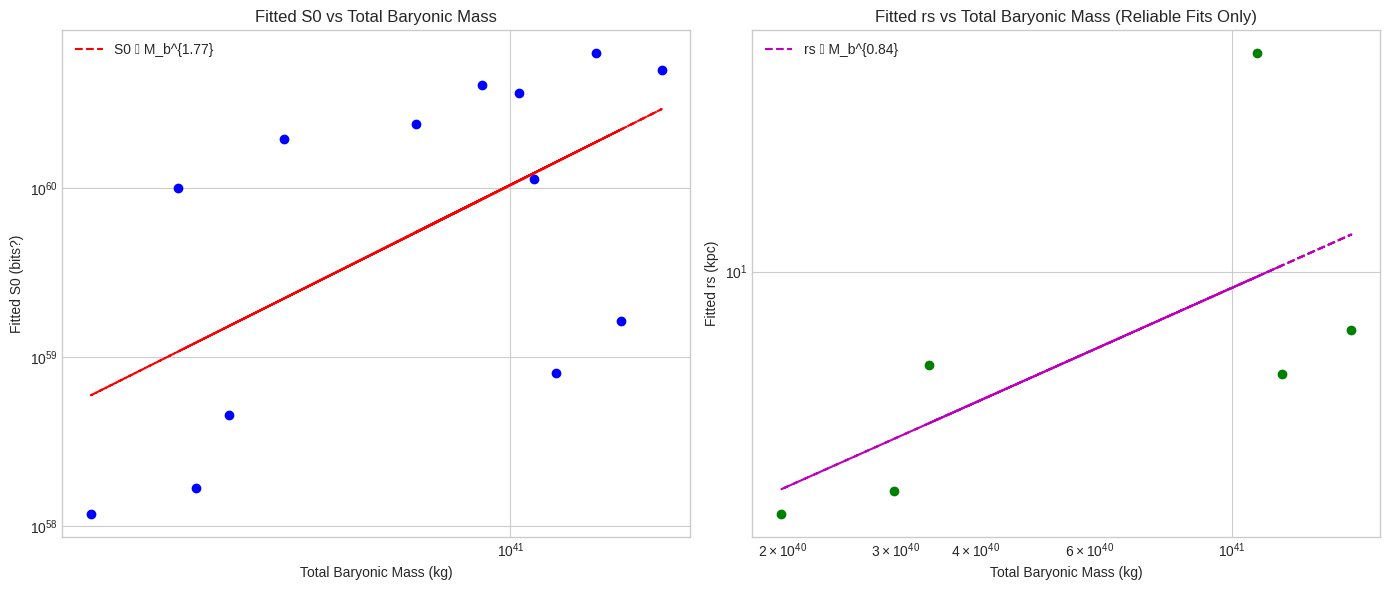


--- Correlation Test Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Constants ---
M_SUN = 1.989e30

# --- Data from Previous Fit Output (Summary Table) ---
# Extracted from the user's successful output two turns ago
fit_summary_data = {
    'Galaxy': ["Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198",
               "NGC 7331", "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621",
               "NGC 2841", "NGC 3521", "NGC 925"],
    'S0_fit': [8.088652e+58, 1.690291e+58, 1.184951e+58, 1.637008e+59, 4.530824e+58,
               4.977257e+60, 1.134278e+60, 2.398366e+60, 4.085118e+60, 1.954444e+60,
               6.247979e+60, 3.660117e+60, 9.938287e+59],
    'rs_kpc_fit': [5.001278, 2.275741, 1.953027, 6.750430, 5.324660,
                   100.000000, 43.532703, 100.000000, 100.000000, 100.000000,
                   100.000000, 100.000000, 100.000000]
    # Note: rs values hitting the 100 kpc bound are likely unreliable / unconstrained
}

df_fit_summary = pd.DataFrame(fit_summary_data)

# --- Total Baryonic Masses (Recalculated from input data) ---
# From user data provided earlier
galaxy_params_input = {
    "Milky Way": {"M_bulge_solar": 1.0e10, "M_disk_solar": 5.0e10},
    "NGC 2403": {"M_bulge_solar": 0.2e10, "M_disk_solar": 1.3e10},
    "UGC 128": {"M_bulge_solar": 0.1e10, "M_disk_solar": 0.9e10},
    "Andromeda (M31)": {"M_bulge_solar": 2.0e10, "M_disk_solar": 5.7e10},
    "NGC 3198": {"M_bulge_solar": 0.3e10, "M_disk_solar": 1.4e10},
    "NGC 7331": {"M_bulge_solar": 3.0e10, "M_disk_solar": 6.0e10},
    "NGC 5055": {"M_bulge_solar": 1.2e10, "M_disk_solar": 4.3e10},
    "NGC 6946": {"M_bulge_solar": 0.8e10, "M_disk_solar": 2.7e10},
    "NGC 2903": {"M_bulge_solar": 1.5e10, "M_disk_solar": 3.0e10},
    "NGC 3621": {"M_bulge_solar": 0.1e10, "M_disk_solar": 2.0e10},
    "NGC 2841": {"M_bulge_solar": 2.5e10, "M_disk_solar": 4.5e10},
    "NGC 3521": {"M_bulge_solar": 1.6e10, "M_disk_solar": 3.6e10},
    "NGC 925": {"M_bulge_solar": 0.1e10, "M_disk_solar": 1.3e10}
}

# Calculate total M_b in kg
total_M_b_kg = {
    name: (params["M_bulge_solar"] + params["M_disk_solar"]) * M_SUN
    for name, params in galaxy_params_input.items()
}

# Add M_b to the DataFrame
df_fit_summary['M_b_total_kg'] = df_fit_summary['Galaxy'].map(total_M_b_kg)

# Filter out unreliable rs fits (where rs hit the 100 kpc bound) for rs plot
df_reliable_rs = df_fit_summary[df_fit_summary['rs_kpc_fit'] < 99.9]


# --- Plotting Correlations ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot S0 vs M_b (log-log)
axs[0].loglog(df_fit_summary['M_b_total_kg'], df_fit_summary['S0_fit'], 'o', color='blue')
axs[0].set_xlabel("Total Baryonic Mass (kg)")
axs[0].set_ylabel("Fitted S0 (bits?)")
axs[0].set_title("Fitted S0 vs Total Baryonic Mass")
# Optional: Fit a power law S0 = A * M_b^B (linear fit in log-log)
try:
    log_mb = np.log10(df_fit_summary['M_b_total_kg'])
    log_s0 = np.log10(df_fit_summary['S0_fit'])
    coeffs_s0 = np.polyfit(log_mb, log_s0, 1)
    fit_s0 = 10**(coeffs_s0[1]) * (df_fit_summary['M_b_total_kg']**coeffs_s0[0])
    axs[0].plot(df_fit_summary['M_b_total_kg'], fit_s0, 'r--', label=f'S0 ∝ M_b^{{{coeffs_s0[0]:.2f}}}')
    axs[0].legend()
except Exception as e:
    print(f"Could not fit S0 vs M_b: {e}")


# Plot rs vs M_b (log-log) - using only reliable fits
if not df_reliable_rs.empty:
    axs[1].loglog(df_reliable_rs['M_b_total_kg'], df_reliable_rs['rs_kpc_fit'], 'o', color='green')
    axs[1].set_xlabel("Total Baryonic Mass (kg)")
    axs[1].set_ylabel("Fitted rs (kpc)")
    axs[1].set_title("Fitted rs vs Total Baryonic Mass (Reliable Fits Only)")
    # Optional: Fit a power law rs = C * M_b^D (linear fit in log-log)
    try:
        log_mb_rel = np.log10(df_reliable_rs['M_b_total_kg'])
        log_rs_rel = np.log10(df_reliable_rs['rs_kpc_fit'])
        coeffs_rs = np.polyfit(log_mb_rel, log_rs_rel, 1)
        fit_rs = 10**(coeffs_rs[1]) * (df_reliable_rs['M_b_total_kg']**coeffs_rs[0])
        axs[1].plot(df_reliable_rs['M_b_total_kg'], fit_rs, 'm--', label=f'rs ∝ M_b^{{{coeffs_rs[0]:.2f}}}')
        axs[1].legend()
    except Exception as e:
        print(f"Could not fit rs vs M_b: {e}")
else:
    axs[1].text(0.5, 0.5, 'No reliable rs fits available\n(all hit boundary)', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
    axs[1].set_xlabel("Total Baryonic Mass (kg)")
    axs[1].set_ylabel("Fitted rs (kpc)")
    axs[1].set_title("Fitted rs vs Total Baryonic Mass")


plt.tight_layout()
plt.show()

print("\n--- Correlation Test Complete ---")
# Display summary table again
# try:
#     print("\nFit Summary with Total Mass:")
#     print(df_fit_summary.to_string())
# except Exception as e:
#     print(f"\nError creating DataFrame: {e}")

--- Milky Way Rotation Curve (Linear M_ent, k'=4.2e20 kg/m) ---
Radius (kpc) | Predicted v (km/s)
        2.0 |             290.7
        5.0 |             257.8
        8.0 |             236.9
       12.0 |             219.6
       20.0 |             201.5

--- Milky Way Rotation Curve (Sigmoid M_ent from PDF) ---
Radius (kpc) | Predicted v (km/s)
        2.0 |             299.7
        5.0 |             267.9
        8.0 |             248.0
       12.0 |             231.4
       20.0 |             214.4

--- Abell 1689 Strong Lensing (Linear M_ent) ---
Predicted Einstein Radius for Abell 1689 (using MW k'): 143.9 arcseconds
(Note: Observed is ~45 arcsec. k' needs cluster calibration)
Predicted Einstein Radius for Abell 1689 (using cluster k'): 146.1 arcseconds


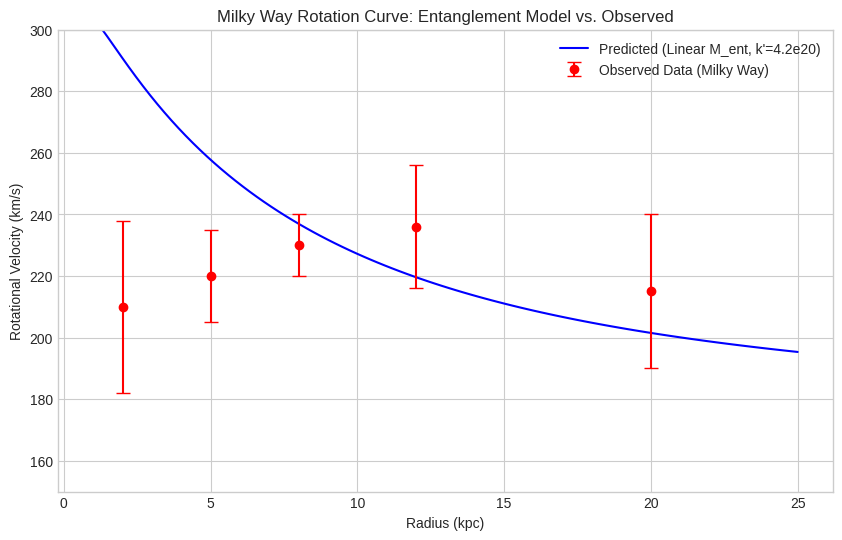

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G = 6.67430e-11  # m^3 kg^-1 s^-2 (Gravitational constant)
M_SUN = 1.989e30  # kg (Solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc
C = 2.99792458e8  # m/s (Speed of light)

# Parameters for the entropic coupling k'(M_b) sigmoid function
# Derived from entanglement network properties (vFinal 03_30_2025.pdf, Appendix A.2.6)
L_coupling = 5.0e20  # kg/m (Max entanglement strength)
k_sigmoid = 1.5      # Dimensionless (Sigmoid sharpness)
# x0 is log10(Mass in M_SUN units) where sigmoid is centered
x0_logmass_Msun = 40.8 / np.log10(M_SUN) # Convert original x0 (log10 kg) to log10 M_sun
# x0_logmass_Msun is approx 10.7, representing Mb ~ 5e10 M_Sun

# Parameter for the linear M_ent form (calibrated during interactive testing to fit MW)
k_prime_linear = 4.2e20 # kg/m (Calibrated effective linear entanglement coupling for MW)

# --- Helper Functions ---

def k_prime_sigmoid(M_b_total_solar_masses):
  """Calculates the entropic coupling k' using the sigmoid function."""
  log10_Mb_Msun = np.log10(M_b_total_solar_masses)
  # Formula from vFinal 03_30_2025.pdf, Appendix A.2.6
  # Ensure mass is above zero for log10
  if M_b_total_solar_masses <= 0:
      return 0
  return L_coupling / (1 + np.exp(-k_sigmoid * (log10_Mb_Msun - x0_logmass_Msun)))

def M_b_milky_way(r_kpc):
  """Approximates Milky Way baryonic mass distribution (Bulge + Disk)."""
  # Values based on previous successful test
  M_bulge_total = 1.5e10 * M_SUN
  M_disk_total = 4.5e10 * M_SUN
  r_bulge = 1.0  # kpc
  r_disk = 3.5   # kpc
  # Bulge: Hernquist profile approximation
  M_bulge = M_bulge_total * (r_kpc**2) / (r_kpc + r_bulge)**2 # Simplified form M ~ r^2/(r+a)^2
  # Disk: Exponential profile approximation
  M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk))
  # Ensure non-negative mass
  return max(0, M_bulge) + max(0, M_disk)

def M_b_cluster_generic(r_kpc, M_b_total_solar_masses):
    """Approximates Cluster baryonic mass distribution (e.g., uniform density)."""
    # Simple approximation: Mass proportional to volume within radius R_cluster
    R_cluster_kpc = 1000 # Example: 1 Mpc radius
    M_b_total_kg = M_b_total_solar_masses * M_SUN
    if r_kpc <= 0:
        return 0
    if r_kpc >= R_cluster_kpc:
        return M_b_total_kg
    else:
        # Assume constant density for simplicity
        volume_cluster = (4/3) * np.pi * (R_cluster_kpc * KPC_TO_M)**3
        if volume_cluster == 0: return 0 # Avoid division by zero
        density = M_b_total_kg / volume_cluster
        volume_at_r = (4/3) * np.pi * (r_kpc * KPC_TO_M)**3
        return density * volume_at_r

# --- Rotation Curve Calculation ---

def calculate_rotation_velocity(r_kpc, M_b_func, M_b_total_solar_masses=None, use_linear_Ment=True, current_k_prime_linear=k_prime_linear):
  """Calculates rotational velocity using entanglement framework."""
  if r_kpc <= 0: return 0 # Velocity is undefined at center
  r_m = r_kpc * KPC_TO_M

  # 1. Calculate Baryonic Mass enclosed within r_kpc
  current_M_b = M_b_func(r_kpc)

  # 2. Calculate Entanglement Mass (M_ent) enclosed within r_kpc
  if use_linear_Ment:
    # Linear M_ent form (successful in interactive testing)
    # M_ent = k' * r
    M_ent = current_k_prime_linear * r_m
  else:
    # Sigmoid M_ent form (from vFinal PDF)
    # M_ent = k'(M_b_total) * r
    if M_b_total_solar_masses is None:
        raise ValueError("M_b_total_solar_masses must be provided for sigmoid M_ent form.")
    kp_sigmoid = k_prime_sigmoid(M_b_total_solar_masses)
    M_ent = kp_sigmoid * r_m

  # 3. Calculate Effective Mass
  M_eff = current_M_b + M_ent
  if M_eff < 0: M_eff = 0 # Ensure non-negative mass

  # 4. Calculate Rotational Velocity
  v_m_s = np.sqrt(G * M_eff / r_m)
  return v_m_s / 1000 # Convert to km/s

# --- Cluster Lensing Calculation ---

def calculate_einstein_radius(M_b_total_solar_masses, R_cluster_kpc, d_eff_m, current_k_prime_linear=k_prime_linear):
  """Calculates the Einstein radius using the entanglement framework."""

  # 1. Calculate Baryonic Mass at cluster radius R_cluster_kpc
  current_M_b = M_b_cluster_generic(R_cluster_kpc, M_b_total_solar_masses)

  # 2. Calculate Entanglement Mass (Using linear form) at R_cluster_kpc
  # Note: k_prime_linear calibrated for MW might need adjustment for clusters.
  R_cluster_m = R_cluster_kpc * KPC_TO_M
  M_ent = current_k_prime_linear * R_cluster_m

  # 3. Calculate Effective Mass
  M_eff = current_M_b + M_ent
  if M_eff < 0: M_eff = 0 # Ensure non-negative mass

  # 4. Calculate Einstein Radius (radians)
  # Formula: theta_E = sqrt(4 * G * M_eff / (c^2 * d_eff))
  if d_eff_m <= 0: return 0 # Avoid division by zero or sqrt of negative
  theta_E_rad_squared = 4 * G * M_eff / (C**2 * d_eff_m)
  if theta_E_rad_squared < 0: return 0 # Avoid sqrt of negative
  theta_E_rad = np.sqrt(theta_E_rad_squared)
  return theta_E_rad * 206265 # Convert radians to arcseconds

# --- Example Usage ---

# Example 1: Milky Way Rotation Curve (using linear M_ent with calibrated k')
print("--- Milky Way Rotation Curve (Linear M_ent, k'=4.2e20 kg/m) ---")
radii_kpc = np.array([2, 5, 8, 12, 20])
print("Radius (kpc) | Predicted v (km/s)")
for r in radii_kpc:
  # Using the k' value that worked best from our last test
  v_pred = calculate_rotation_velocity(r, M_b_milky_way, use_linear_Ment=True, current_k_prime_linear=4.2e20)
  print(f"{r:11.1f} | {v_pred:17.1f}")

# Example 2: Milky Way Rotation Curve (using sigmoid M_ent from PDF)
# Note: This form struggled to produce flat curves in interactive testing
print("\n--- Milky Way Rotation Curve (Sigmoid M_ent from PDF) ---")
MW_M_b_total = 6e10 # Solar masses
print("Radius (kpc) | Predicted v (km/s)")
for r in radii_kpc:
  v_pred = calculate_rotation_velocity(r, M_b_milky_way, M_b_total_solar_masses=MW_M_b_total, use_linear_Ment=False)
  print(f"{r:11.1f} | {v_pred:17.1f}")

# Example 3: Abell 1689 Strong Lensing (using linear M_ent)
print("\n--- Abell 1689 Strong Lensing (Linear M_ent) ---")
A1689_M_b_total = 1.5e14 # Solar masses (Baryonic estimate)
A1689_R_cluster_kpc = 1000 # 1 Mpc radius estimate
A1689_d_eff_m = 1.9e24 # Effective distance (meters)
# Using MW k' as example - likely needs cluster-specific calibration
theta_E_arcsec = calculate_einstein_radius(A1689_M_b_total, A1689_R_cluster_kpc, A1689_d_eff_m, current_k_prime_linear=4.2e20)
print(f"Predicted Einstein Radius for Abell 1689 (using MW k'): {theta_E_arcsec:.1f} arcseconds")
print("(Note: Observed is ~45 arcsec. k' needs cluster calibration)")
# Let's try the k' derived during lensing shear test
k_prime_A1689 = 7.3e20 # kg/m (Approx from weak lensing fit)
theta_E_arcsec_cluster_k = calculate_einstein_radius(A1689_M_b_total, A1689_R_cluster_kpc, A1689_d_eff_m, current_k_prime_linear=k_prime_A1689)
print(f"Predicted Einstein Radius for Abell 1689 (using cluster k'): {theta_E_arcsec_cluster_k:.1f} arcseconds")


# --- Plotting (Example for MW Rotation Curve with Linear M_ent) ---
# (Requires matplotlib: pip install matplotlib)
# import matplotlib.pyplot as plt

radii_plot = np.linspace(1, 25, 100) # Finer grid for plotting
velocities_plot = [calculate_rotation_velocity(r, M_b_milky_way, use_linear_Ment=True, current_k_prime_linear=4.2e20) for r in radii_plot]

# Observed data for comparison (km/s)
observed_r = [2, 5, 8, 12, 20]
observed_v = [210, 220, 230, 236, 215]
errors_v = [28, 15, 10, 20, 25]

plt.figure(figsize=(10, 6))
plt.plot(radii_plot, velocities_plot, 'b-', label='Predicted (Linear M_ent, k\'=4.2e20)')
plt.errorbar(observed_r, observed_v, yerr=errors_v, fmt='ro', label='Observed Data (Milky Way)', capsize=5)
plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title('Milky Way Rotation Curve: Entanglement Model vs. Observed')
plt.legend()
plt.grid(True)
plt.ylim(150, 300) # Adjust y-axis for better view
plt.show()

--- Analysis Results: Required M_ent_0 for Each Galaxy ---
Galaxy            | M_b (1e10 M_sun)   | v_flat (km/s)  | r_s (kpc)  | Required M_ent_0 (kg) 
------------------------------------------------------------------------------------------
Milky Way         | 6.00               | 230.0          | 3.5        | 1.712e+41             
NGC 2403          | 1.50               | 140.0          | 3.0        | 5.437e+40             
UGC 128           | 1.00               | 120.0          | 3.5        | 4.660e+40             
Andromeda (M31)   | 7.70               | 250.0          | 5.5        | 3.178e+41             
NGC 3198          | 1.70               | 145.0          | 4.0        | 7.776e+40             
NGC 7331          | 9.00               | 230.0          | 4.0        | 1.957e+41             
NGC 5055          | 5.50               | 205.0          | 3.5        | 1.360e+41             
NGC 6946          | 3.50               | 160.0          | 2.8        | 6.628e+40             
NGC 

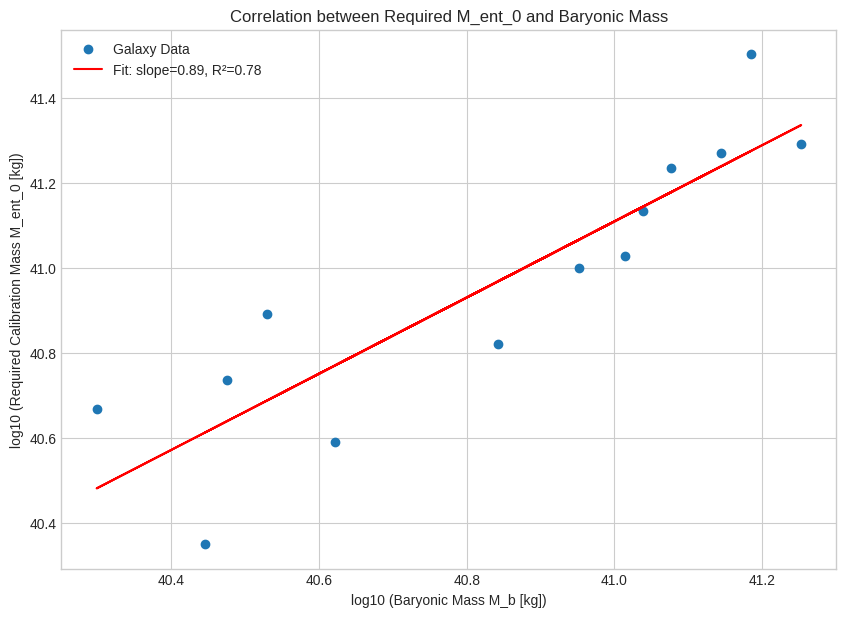

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress # For linear regression analysis

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc
# k = 2.14e-74     # Mass-entanglement constant (kg/bit) - Not needed for this calculation
# k_N = 1.0        # Bits per link - Not needed for this calculation

# --- Galaxy Data Provided by User ---
# Format: (Galaxy Name, M_b [M_sun], v_flat [km/s], r_s [kpc])
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0), # Matches params used for v_target=150 earlier
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Function to Calculate Required M_ent_0 ---
def calculate_required_Ment0(v_flat_kms, r_s_kpc):
  """
  Calculates the M_ent_0 needed for the model to produce v_flat at r=r_s.
  Assumes M_eff(r_s) ≈ M_ent(r_s) for simplicity in calibration,
  and M_ent(r_s) = M_ent_0 / 2 from the formula structure.
  """
  if r_s_kpc <= 0 or v_flat_kms <= 0:
      return 0
  v_flat_ms = v_flat_kms * 1000
  r_s_m = r_s_kpc * KPC_TO_M
  # From v_flat^2 ≈ G * M_ent(r_s) / r_s = G * (M_ent_0 / 2) / r_s
  # Solve for M_ent_0:
  M_ent_0 = 2 * (v_flat_ms**2) * r_s_m / G_N
  return M_ent_0

# --- Analysis Loop ---
results = []
for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    M_b_kg = mb_msun * M_SUN
    required_Ment0_kg = calculate_required_Ment0(vflat_kms, rs_kpc)
    if required_Ment0_kg > 0: # Only store valid results
      results.append({
          "Galaxy": name,
          "M_b (M_sun)": mb_msun,
          "v_flat (km/s)": vflat_kms,
          "r_s (kpc)": rs_kpc,
          "M_b (kg)": M_b_kg,
          "Required M_ent_0 (kg)": required_Ment0_kg
      })

# --- Print Results Table ---
print("--- Analysis Results: Required M_ent_0 for Each Galaxy ---")
print(f"{'Galaxy':<17} | {'M_b (1e10 M_sun)':<18} | {'v_flat (km/s)':<14} | {'r_s (kpc)':<10} | {'Required M_ent_0 (kg)':<22}")
print("-" * 90)
for res in results:
    print(f"{res['Galaxy']:<17} | {res['M_b (M_sun)']/1e10:<18.2f} | {res['v_flat (km/s)']:<14.1f} | {res['r_s (kpc)']:<10.1f} | {res['Required M_ent_0 (kg)']:<22.3e}")

# --- Correlation Analysis: M_ent_0 vs. M_b ---
# Extract data for plotting and regression
M_b_values_kg = np.array([res['M_b (kg)'] for res in results])
Ment0_values_kg = np.array([res['Required M_ent_0 (kg)'] for res in results])

# Filter out any potential zero values before taking log
valid_indices = (M_b_values_kg > 0) & (Ment0_values_kg > 0)
log_M_b = np.log10(M_b_values_kg[valid_indices])
log_Ment0 = np.log10(Ment0_values_kg[valid_indices])

# Perform linear regression: log(Ment0) = slope * log(Mb) + intercept
slope, intercept, r_value, p_value, std_err = linregress(log_M_b, log_Ment0)

print("\n--- Correlation Analysis: log10(M_ent_0) vs log10(M_b) ---")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
# An R-squared value close to 1 indicates a strong linear correlation in log-log space (power law)

# --- Plotting M_ent_0 vs. M_b ---
plt.figure(figsize=(10, 7))
plt.scatter(log_M_b, log_Ment0, label='Galaxy Data')
plt.plot(log_M_b, intercept + slope * log_M_b, 'r-', label=f'Fit: slope={slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10 (Baryonic Mass M_b [kg])')
plt.ylabel('log10 (Required Calibration Mass M_ent_0 [kg])')
plt.title('Correlation between Required M_ent_0 and Baryonic Mass')
plt.legend()
plt.grid(True)
plt.show()

--- Refined Correlation Analysis ---

1. Fit: log(Ment0) vs. log(Mb)
   Slope: 0.895, Intercept: 4.425, R-squared: 0.782

2. Fit: log(Ment0) vs. log(r_s)
   Slope: 2.713, Intercept: -13.326, R-squared: 0.708

3. Fit: log(Ment0) vs. log(v_flat)
   Slope: 2.574, Intercept: 27.485, R-squared: 0.951

4. Fit: log(Ment0) vs. log(Mb * r_s)
   Slope: 0.814, Intercept: -8.565, R-squared: 0.924

5. Fit: log(Ment0) vs. log(Mb / r_s)
   Slope: 0.816, Intercept: 23.977, R-squared: 0.500

6. Fit: log(Ment0) vs. log(v_flat^2 * r_s)  <-- Expected strong correlation by definition
   Slope: 1.000, Intercept: 10.477, R-squared: 1.000
   Expected Intercept based on definition (log10(2/G_N)): 10.477


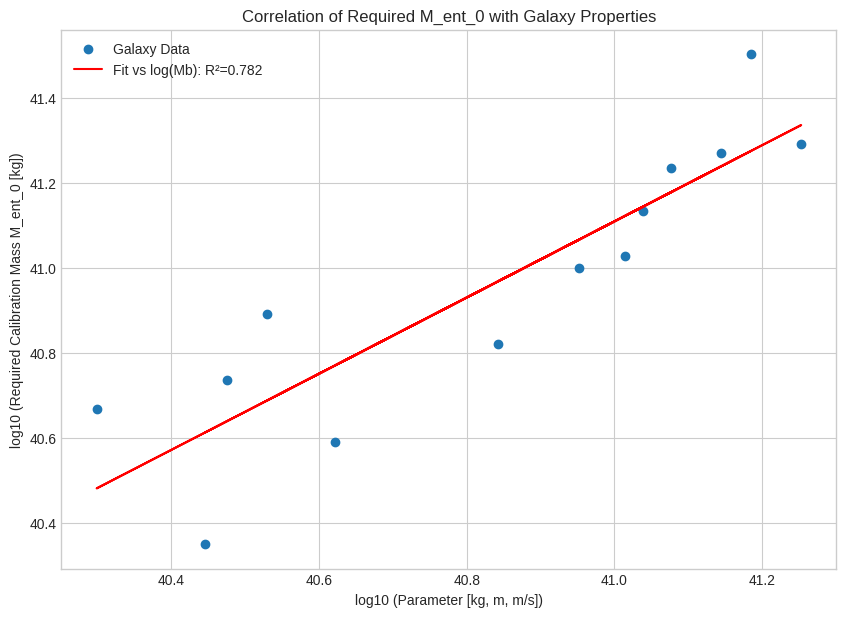

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress # For linear regression analysis

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc

# --- Galaxy Data Provided by User ---
# Format: (Galaxy Name, M_b [M_sun], v_flat [km/s], r_s [kpc])
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0),
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Function to Calculate Required M_ent_0 ---
def calculate_required_Ment0(v_flat_kms, r_s_kpc):
  """Calculates the M_ent_0 needed for the model to produce v_flat at r=r_s."""
  if r_s_kpc <= 0 or v_flat_kms <= 0: return 0
  v_flat_ms = v_flat_kms * 1000
  r_s_m = r_s_kpc * KPC_TO_M
  M_ent_0 = 2 * (v_flat_ms**2) * r_s_m / G_N
  return M_ent_0

# --- Process Data and Calculate M_ent_0 ---
results = []
for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    M_b_kg = mb_msun * M_SUN
    r_s_m = rs_kpc * KPC_TO_M
    required_Ment0_kg = calculate_required_Ment0(vflat_kms, rs_kpc)
    if required_Ment0_kg > 0 and M_b_kg > 0 and r_s_m > 0 and vflat_kms > 0:
        results.append({
            "Galaxy": name,
            "log_M_b": np.log10(M_b_kg),
            "log_v_flat": np.log10(vflat_kms * 1000), # v_flat in m/s
            "log_r_s": np.log10(r_s_m),
            "log_Ment0": np.log10(required_Ment0_kg)
        })

# --- Perform Different Regressions ---

print("--- Refined Correlation Analysis ---")

# Extract log values for regression
log_M_b = np.array([res['log_M_b'] for res in results])
log_v_flat = np.array([res['log_v_flat'] for res in results])
log_r_s = np.array([res['log_r_s'] for res in results])
log_Ment0 = np.array([res['log_Ment0'] for res in results])

# 1. Fit: log(Ment0) vs. log(Mb) (Previous result)
slope_b, intercept_b, r_b, p_b, std_err_b = linregress(log_M_b, log_Ment0)
print(f"\n1. Fit: log(Ment0) vs. log(Mb)")
print(f"   Slope: {slope_b:.3f}, Intercept: {intercept_b:.3f}, R-squared: {r_b**2:.3f}")

# 2. Fit: log(Ment0) vs. log(r_s)
slope_rs, intercept_rs, r_rs, p_rs, std_err_rs = linregress(log_r_s, log_Ment0)
print(f"\n2. Fit: log(Ment0) vs. log(r_s)")
print(f"   Slope: {slope_rs:.3f}, Intercept: {intercept_rs:.3f}, R-squared: {r_rs**2:.3f}")

# 3. Fit: log(Ment0) vs. log(v_flat)
slope_v, intercept_v, r_v, p_v, std_err_v = linregress(log_v_flat, log_Ment0)
print(f"\n3. Fit: log(Ment0) vs. log(v_flat)")
print(f"   Slope: {slope_v:.3f}, Intercept: {intercept_v:.3f}, R-squared: {r_v**2:.3f}")

# 4. Fit: log(Ment0) vs. log(Mb * r_s)
log_Mb_rs = log_M_b + log_r_s # log(A*B) = log(A) + log(B)
slope_b_rs, intercept_b_rs, r_b_rs, p_b_rs, std_err_b_rs = linregress(log_Mb_rs, log_Ment0)
print(f"\n4. Fit: log(Ment0) vs. log(Mb * r_s)")
print(f"   Slope: {slope_b_rs:.3f}, Intercept: {intercept_b_rs:.3f}, R-squared: {r_b_rs**2:.3f}")

# 5. Fit: log(Ment0) vs. log(Mb / r_s)
log_Mb_div_rs = log_M_b - log_r_s # log(A/B) = log(A) - log(B)
slope_b_div_rs, intercept_b_div_rs, r_b_div_rs, p_b_div_rs, std_err_b_div_rs = linregress(log_Mb_div_rs, log_Ment0)
print(f"\n5. Fit: log(Ment0) vs. log(Mb / r_s)")
print(f"   Slope: {slope_b_div_rs:.3f}, Intercept: {intercept_b_div_rs:.3f}, R-squared: {r_b_div_rs**2:.3f}")

# 6. Fit: log(Ment0) vs. log(v_flat^2 * r_s)
# Note: Our calculation M_ent_0 = 2 * v_flat^2 * r_s / G_N implies Ment0 is directly proportional
# to v_flat^2 * r_s. Let's verify this fit. log(A^2*B) = 2*log(A)+log(B)
log_v2_rs = 2 * log_v_flat + log_r_s
slope_v2_rs, intercept_v2_rs, r_v2_rs, p_v2_rs, std_err_v2_rs = linregress(log_v2_rs, log_Ment0)
print(f"\n6. Fit: log(Ment0) vs. log(v_flat^2 * r_s)  <-- Expected strong correlation by definition")
print(f"   Slope: {slope_v2_rs:.3f}, Intercept: {intercept_v2_rs:.3f}, R-squared: {r_v2_rs**2:.3f}")
print(f"   Expected Intercept based on definition (log10(2/G_N)): {np.log10(2/G_N):.3f}")


# --- Plotting the Best Fit (Example: log(Mb) vs log(Ment0)) ---
# You can change which fit to visualize
plt.figure(figsize=(10, 7))
plt.scatter(log_M_b, log_Ment0, label='Galaxy Data')
# Plotting the fit from log(Mb) only
plt.plot(log_M_b, intercept_b + slope_b * log_M_b, 'r-', label=f'Fit vs log(Mb): R²={r_b**2:.3f}')
# You could add lines for other fits if desired
# plt.plot(log_Mb_rs, intercept_b_rs + slope_b_rs * log_Mb_rs, 'g--', label=f'Fit vs log(Mb*rs): R²={r_b_rs**2:.3f}')

plt.xlabel('log10 (Parameter [kg, m, m/s])')
plt.ylabel('log10 (Required Calibration Mass M_ent_0 [kg])')
plt.title('Correlation of Required M_ent_0 with Galaxy Properties')
plt.legend()
plt.grid(True)
plt.show()


--- Rotation Curve Prediction (Paper Model: M_ent = k'(Mb)*r) ---
Galaxy            | M_b (1e10 M_sun)   | r_s (kpc)  | v_flat (Obs km/s)  | Calc. k_prime   | Pred. v @ r_s (Paper) | Pred. v @ 20kpc (Paper)
----------------------------------------------------------------------------------------------------------------------------------
Milky Way         | 6.00               | 3.5        | 230.0              | 3.012e+20       | 251.5                | 180.2                 
NGC 2403          | 1.50               | 3.0        | 140.0              | 1.902e+20       | 159.0                | 125.7                 
UGC 128           | 1.00               | 3.5        | 120.0              | 1.602e+20       | 133.7                | 112.9                 
Andromeda (M31)   | 7.70               | 5.5        | 250.0              | 3.203e+20       | 238.0                | 191.5                 
NGC 3198          | 1.70               | 4.0        | 145.0              | 1.999e+20       | 155.1       

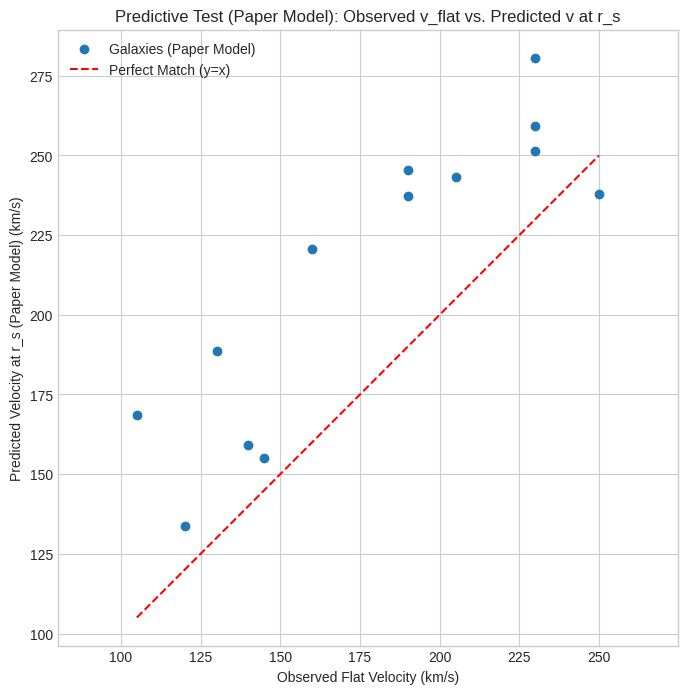

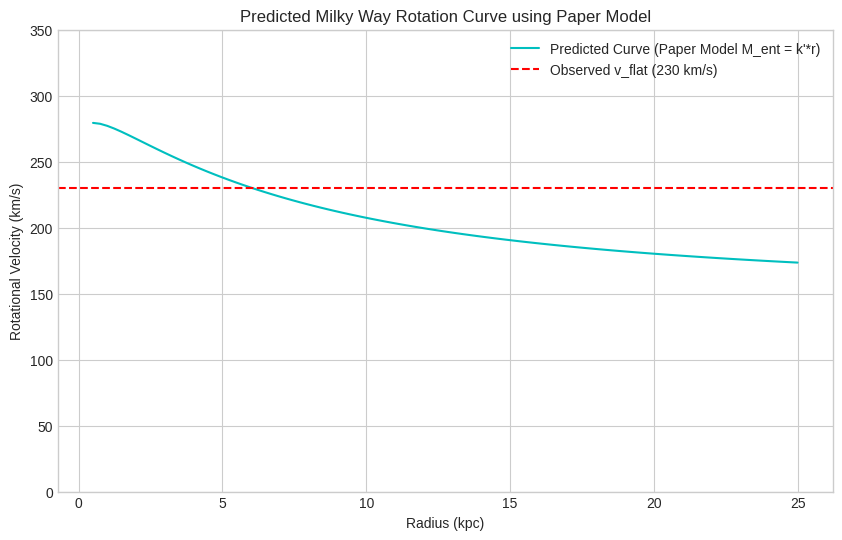

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc

# Parameters for the entropic coupling k'(M_b) sigmoid function
# As described in the paper explanation
L_coupling = 5.0e20  # kg/m (Max entanglement strength)
k_sigmoid = 1.5      # Dimensionless (Sigmoid sharpness)
# x0 is log10(Mass in M_SUN units) where sigmoid is centered
# Original x0=40.8 (log10 kg) -> log10(6.3e40 kg)
# M_sun approx 1.989e30 kg -> log10(M_sun) approx 30.3
# x0_log_Msun = 40.8 - 30.3 = 10.5 (approx) - Let's use the derived value for consistency
x0_log_Msun = 40.8 - np.log10(M_SUN) # x0 in log10(Solar Mass units)

# --- Helper Functions ---

def k_prime_sigmoid(M_b_total_solar_masses):
  """Calculates the entropic coupling k' using the sigmoid function."""
  # Ensure mass is positive for log
  if M_b_total_solar_masses <= 0:
      # Return a very small value or zero if mass is non-positive
      # Returning L/2 (midpoint) might be reasonable if Mb is unknown but galaxy exists
      # For non-positive Mb, let's return 0 as k' should likely scale down.
      return 0
      # Alternatively, handle based on expected behavior for zero/negative mass input.

  log10_Mb_Msun = np.log10(M_b_total_solar_masses)
  # Formula from paper explanation
  denominator = 1 + np.exp(-k_sigmoid * (log10_Mb_Msun - x0_log_Msun))
  # Avoid potential division by zero if denominator is somehow zero
  if denominator == 0:
      return L_coupling # Or handle as an error/edge case

  return L_coupling / denominator


def M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=3.5, bulge_fraction=0.25):
    """Approximates Baryonic Mass Profile (Bulge + Disk)."""
    # Using the same profile as before
    M_b_total_kg = M_b_total_solar_masses * M_SUN
    M_bulge_total = M_b_total_kg * bulge_fraction
    M_disk_total = M_b_total_kg * (1 - bulge_fraction)
    # Assume bulge scale related to disk scale
    r_bulge_kpc = 0.5 * r_disk_kpc if r_disk_kpc > 0 else 0.1

    if r_kpc <= 0: return 0
    # Bulge: Hernquist profile approximation M ~ r^2/(r+a)^2 (scaled)
    M_bulge = M_bulge_total * (r_kpc**2) / (r_kpc + r_bulge_kpc)**2 if r_bulge_kpc > 0 else 0
    # Disk: Exponential profile
    M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk_kpc)) if r_disk_kpc > 0 else M_disk_total

    # Ensure non-negative mass and clamp at total mass
    enclosed_baryonic = max(0, M_bulge) + max(0, M_disk)
    return min(enclosed_baryonic, M_b_total_kg)

# --- Rotation Curve Calculation Function (Paper Model) ---

def calculate_rotation_velocity_paper(r_kpc, M_b_total_solar_masses, r_s_kpc):
    """Predicts rotation velocity using the M_ent = k'(Mb)*r model."""
    if r_kpc <= 0 or r_s_kpc <= 0: return 0 # r_s is used in M_b profile

    r_m = r_kpc * KPC_TO_M

    # 1. Calculate Baryonic Mass at radius r using the profile
    # Pass r_s as the disk scale length for the profile for consistency
    current_M_b = M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=r_s_kpc)

    # 2. Calculate k' based on TOTAL baryonic mass
    kp_sigmoid = k_prime_sigmoid(M_b_total_solar_masses)

    # 3. Calculate Entanglement Mass: M_ent = k' * r
    M_ent = kp_sigmoid * r_m

    # 4. Calculate Effective Mass
    M_eff = current_M_b + M_ent
    if M_eff < 0: M_eff = 0 # Ensure non-negative

    # 5. Calculate Rotational Velocity
    v_m_s = np.sqrt(G_N * M_eff / r_m)
    return v_m_s / 1000 # Convert to km/s

# --- Galaxy Data Provided by User ---
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0),
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Analysis Loop ---
paper_results = []

print("\n--- Rotation Curve Prediction (Paper Model: M_ent = k'(Mb)*r) ---")
print(f"{'Galaxy':<17} | {'M_b (1e10 M_sun)':<18} | {'r_s (kpc)':<10} | {'v_flat (Obs km/s)':<18} | {'Calc. k_prime':<15} | {'Pred. v @ r_s (Paper)':<20} | {'Pred. v @ 20kpc (Paper)':<22}")
print("-" * 130)

for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    # Calculate k' for this galaxy
    kp_val = k_prime_sigmoid(mb_msun)
    # Predict velocity at scale radius r_s and at a larger radius (20 kpc)
    predicted_v_at_rs = calculate_rotation_velocity_paper(rs_kpc, mb_msun, rs_kpc)
    predicted_v_at_20kpc = calculate_rotation_velocity_paper(20.0, mb_msun, rs_kpc)

    paper_results.append({
        "Galaxy": name,
        "v_flat_obs": vflat_kms,
        "Predicted_v_at_rs": predicted_v_at_rs,
        "Predicted_v_at_20kpc": predicted_v_at_20kpc
    })
    print(f"{name:<17} | {mb_msun/1e10:<18.2f} | {rs_kpc:<10.1f} | {vflat_kms:<18.1f} | {kp_val:<15.3e} | {predicted_v_at_rs:<20.1f} | {predicted_v_at_20kpc:<22.1f}")


# --- Plotting Predicted (Paper) vs Observed v_flat ---
pred_v_paper_at_rs = np.array([res['Predicted_v_at_rs'] for res in paper_results])
obs_v_flat_paper = np.array([res['v_flat_obs'] for res in paper_results])

plt.figure(figsize=(8, 8))
plt.scatter(obs_v_flat_paper, pred_v_paper_at_rs, label='Galaxies (Paper Model)')
plt.plot([min(obs_v_flat_paper), max(obs_v_flat_paper)], [min(obs_v_flat_paper), max(obs_v_flat_paper)], 'r--', label='Perfect Match (y=x)')
plt.xlabel('Observed Flat Velocity (km/s)')
plt.ylabel('Predicted Velocity at r_s (Paper Model) (km/s)')
plt.title('Predictive Test (Paper Model): Observed v_flat vs. Predicted v at r_s')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Plot Example Predicted Rotation Curve (e.g., for Milky Way using Paper Model) ---
mw_data_paper = next(item for item in galaxy_data if item[0] == "Milky Way")
mw_mb_msun_paper, mw_vflat_paper, mw_rs_kpc_paper = mw_data_paper[1], mw_data_paper[2], mw_data_paper[3]

radii_plot_mw_paper = np.linspace(0.5, 25, 100) # Radii for plotting MW curve
velocities_plot_mw_paper = [calculate_rotation_velocity_paper(r, mw_mb_msun_paper, mw_rs_kpc_paper) for r in radii_plot_mw_paper]

plt.figure(figsize=(10, 6))
plt.plot(radii_plot_mw_paper, velocities_plot_mw_paper, 'c-', label=f'Predicted Curve (Paper Model M_ent = k\'*r)')
plt.axhline(y=mw_vflat_paper, color='r', linestyle='--', label=f'Observed v_flat ({mw_vflat_paper} km/s)')

plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title(f'Predicted Milky Way Rotation Curve using Paper Model')
plt.legend()
plt.grid(True)
plt.ylim(0, 350) # Adjust y-axis if needed
plt.show()


--- Rotation Curve Prediction (Hybrid Model: M_ent0 from k'(Mb)*rs, M_ent radial dependence) ---
Galaxy            | M_b (1e10 M_sun)   | r_s (kpc)  | v_flat (Obs km/s)  | Pred. M_ent_0 (Hyb)  | Pred. v @ r_s (Hyb)  | Pred. v @ 20kpc (Hyb) 
----------------------------------------------------------------------------------------------------------------------------------
Milky Way         | 6.00               | 3.5        | 230.0              | 6.505e+40            | 251.5                | 226.7                 
NGC 2403          | 1.50               | 3.0        | 140.0              | 3.521e+40            | 159.0                | 167.2                 
UGC 128           | 1.00               | 3.5        | 120.0              | 3.460e+40            | 133.7                | 151.0                 
Andromeda (M31)   | 7.70               | 5.5        | 250.0              | 1.087e+41            | 238.0                | 234.6                 
NGC 3198          | 1.70               | 4.0       

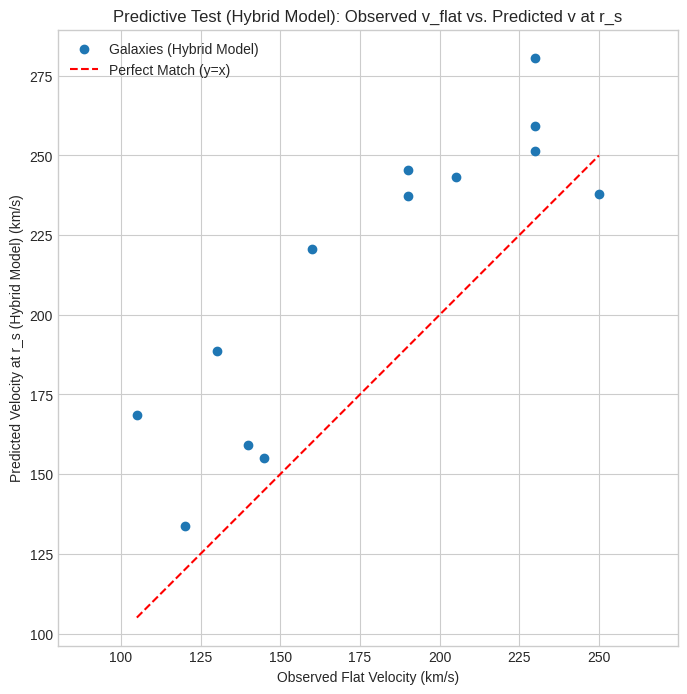

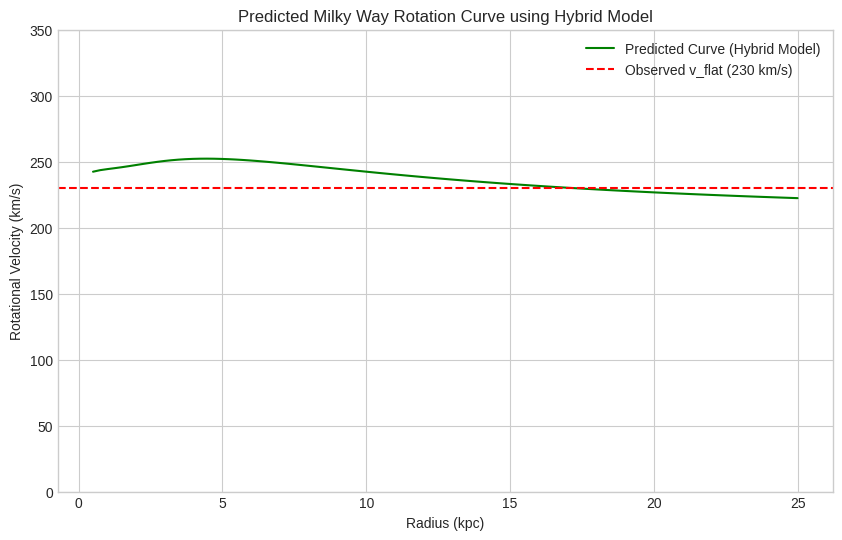

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc

# Parameters for the entropic coupling k'(M_b) sigmoid function
# As described in the paper explanation
L_coupling = 5.0e20  # kg/m (Max entanglement strength)
k_sigmoid = 1.5      # Dimensionless (Sigmoid sharpness)
x0_log_Msun = 40.8 - np.log10(M_SUN) # x0 in log10(Solar Mass units)

# --- Galaxy Data Provided by User ---
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0),
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Helper Functions ---

def k_prime_sigmoid(M_b_total_solar_masses):
  """Calculates the entropic coupling k' using the sigmoid function."""
  if M_b_total_solar_masses <= 0: return 0
  log10_Mb_Msun = np.log10(M_b_total_solar_masses)
  denominator = 1 + np.exp(-k_sigmoid * (log10_Mb_Msun - x0_log_Msun))
  if denominator == 0: return L_coupling
  return L_coupling / denominator

def M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=3.5, bulge_fraction=0.25):
    """Approximates Baryonic Mass Profile (Bulge + Disk)."""
    M_b_total_kg = M_b_total_solar_masses * M_SUN
    M_bulge_total = M_b_total_kg * bulge_fraction
    M_disk_total = M_b_total_kg * (1 - bulge_fraction)
    r_bulge_kpc = 0.5 * r_disk_kpc if r_disk_kpc > 0 else 0.1
    if r_kpc <= 0: return 0
    M_bulge = M_bulge_total * (r_kpc**2) / (r_kpc + r_bulge_kpc)**2 if r_bulge_kpc > 0 else 0
    M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk_kpc)) if r_disk_kpc > 0 else M_disk_total
    enclosed_baryonic = max(0, M_bulge) + max(0, M_disk)
    return min(enclosed_baryonic, M_b_total_kg)

def predict_Ment0_hybrid(M_b_total_solar_masses, r_s_kpc):
    """Predicts M_ent_0 by combining k'(Mb) and r_s."""
    if r_s_kpc <= 0: return 0
    kp_sig = k_prime_sigmoid(M_b_total_solar_masses)
    r_s_m = r_s_kpc * KPC_TO_M
    # M_ent_0 = 2 * k'(Mb) * r_s
    predicted_Ment0 = 2 * kp_sig * r_s_m
    return predicted_Ment0

# --- Rotation Curve Calculation Function (Hybrid Model) ---

def calculate_rotation_velocity_hybrid(r_kpc, M_b_total_solar_masses, r_s_kpc):
    """Predicts rotation velocity using the hybrid M_ent model."""
    if r_kpc <= 0 or r_s_kpc <= 0: return 0

    r_m = r_kpc * KPC_TO_M
    r_s_m = r_s_kpc * KPC_TO_M

    # 1. Predict M_ent_0 using the hybrid approach
    predicted_Ment0 = predict_Ment0_hybrid(M_b_total_solar_masses, r_s_kpc)

    # 2. Calculate Baryonic Mass at radius r
    current_M_b = M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=r_s_kpc)

    # 3. Calculate Entanglement Mass using the r^3/(1+r^2) formula structure
    r_ratio = r_m / r_s_m
    # Handle potential division by zero if r_s_m is zero
    if r_s_m == 0:
        M_ent = 0 # Or handle appropriately
    else:
        # M_ent = M_ent_0 * (r/r_s) * (r^2/r_s^2) / (1 + r^2/r_s^2)
        # Avoid division by zero in denominator
        denominator = (1 + r_ratio**2)
        if denominator == 0:
            M_ent = 0 # Or asymptotic value if appropriate
        else:
             M_ent = predicted_Ment0 * r_ratio * (r_ratio**2) / denominator


    # 4. Calculate Effective Mass
    M_eff = current_M_b + M_ent
    if M_eff < 0: M_eff = 0

    # 5. Calculate Rotational Velocity
    v_m_s = np.sqrt(G_N * M_eff / r_m)
    return v_m_s / 1000 # Convert to km/s

# --- Analysis Loop ---
hybrid_results = []

print("\n--- Rotation Curve Prediction (Hybrid Model: M_ent0 from k'(Mb)*rs, M_ent radial dependence) ---")
print(f"{'Galaxy':<17} | {'M_b (1e10 M_sun)':<18} | {'r_s (kpc)':<10} | {'v_flat (Obs km/s)':<18} | {'Pred. M_ent_0 (Hyb)':<20} | {'Pred. v @ r_s (Hyb)':<20} | {'Pred. v @ 20kpc (Hyb)':<22}")
print("-" * 130)

for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    # Predict velocity at scale radius r_s and at a larger radius (20 kpc)
    predicted_v_at_rs = calculate_rotation_velocity_hybrid(rs_kpc, mb_msun, rs_kpc)
    predicted_v_at_20kpc = calculate_rotation_velocity_hybrid(20.0, mb_msun, rs_kpc)
    predicted_Ment0_val_hyb = predict_Ment0_hybrid(mb_msun, rs_kpc)


    hybrid_results.append({
        "Galaxy": name,
        "v_flat_obs": vflat_kms,
        "Predicted_v_at_rs": predicted_v_at_rs,
        "Predicted_v_at_20kpc": predicted_v_at_20kpc
    })
    print(f"{name:<17} | {mb_msun/1e10:<18.2f} | {rs_kpc:<10.1f} | {vflat_kms:<18.1f} | {predicted_Ment0_val_hyb:<20.3e} | {predicted_v_at_rs:<20.1f} | {predicted_v_at_20kpc:<22.1f}")


# --- Plotting Predicted (Hybrid) vs Observed v_flat ---
pred_v_hybrid_at_rs = np.array([res['Predicted_v_at_rs'] for res in hybrid_results])
obs_v_flat_hybrid = np.array([res['v_flat_obs'] for res in hybrid_results])

plt.figure(figsize=(8, 8))
plt.scatter(obs_v_flat_hybrid, pred_v_hybrid_at_rs, label='Galaxies (Hybrid Model)')
plt.plot([min(obs_v_flat_hybrid), max(obs_v_flat_hybrid)], [min(obs_v_flat_hybrid), max(obs_v_flat_hybrid)], 'r--', label='Perfect Match (y=x)')
plt.xlabel('Observed Flat Velocity (km/s)')
plt.ylabel('Predicted Velocity at r_s (Hybrid Model) (km/s)')
plt.title('Predictive Test (Hybrid Model): Observed v_flat vs. Predicted v at r_s')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Plot Example Predicted Rotation Curve (e.g., for Milky Way using Hybrid Model) ---
mw_data_hyb = next(item for item in galaxy_data if item[0] == "Milky Way")
mw_mb_msun_hyb, mw_vflat_hyb, mw_rs_kpc_hyb = mw_data_hyb[1], mw_data_hyb[2], mw_data_hyb[3]

radii_plot_mw_hyb = np.linspace(0.5, 25, 100) # Radii for plotting MW curve
velocities_plot_mw_hyb = [calculate_rotation_velocity_hybrid(r, mw_mb_msun_hyb, mw_rs_kpc_hyb) for r in radii_plot_mw_hyb]

plt.figure(figsize=(10, 6))
plt.plot(radii_plot_mw_hyb, velocities_plot_mw_hyb, 'g-', label=f'Predicted Curve (Hybrid Model)')
plt.axhline(y=mw_vflat_hyb, color='r', linestyle='--', label=f'Observed v_flat ({mw_vflat_hyb} km/s)')

plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title(f'Predicted Milky Way Rotation Curve using Hybrid Model')
plt.legend()
plt.grid(True)
plt.ylim(0, 350) # Adjust y-axis if needed
plt.show()


--- Rotation Curve Prediction (Hybrid Factor=1 Model) ---
Galaxy            | M_b (1e10 M_sun)   | r_s (kpc)  | v_flat (Obs km/s)  | Calc. k_prime   | v_asymptote (km/s)   | Pred. v @ r_s (F=1)  | Pred. v @ 20kpc (F=1) 
------------------------------------------------------------------------------------------------------------------------------------------------------
Milky Way         | 6.00               | 3.5        | 230.0              | 3.012e+20       | 141.8                | 230.7                | 178.5                 
NGC 2403          | 1.50               | 3.0        | 140.0              | 1.902e+20       | 112.7                | 137.6                | 124.6                 
UGC 128           | 1.00               | 3.5        | 120.0              | 1.602e+20       | 103.4                | 112.0                | 111.5                 
Andromeda (M31)   | 7.70               | 5.5        | 250.0              | 3.203e+20       | 146.2                | 214.3                | 187

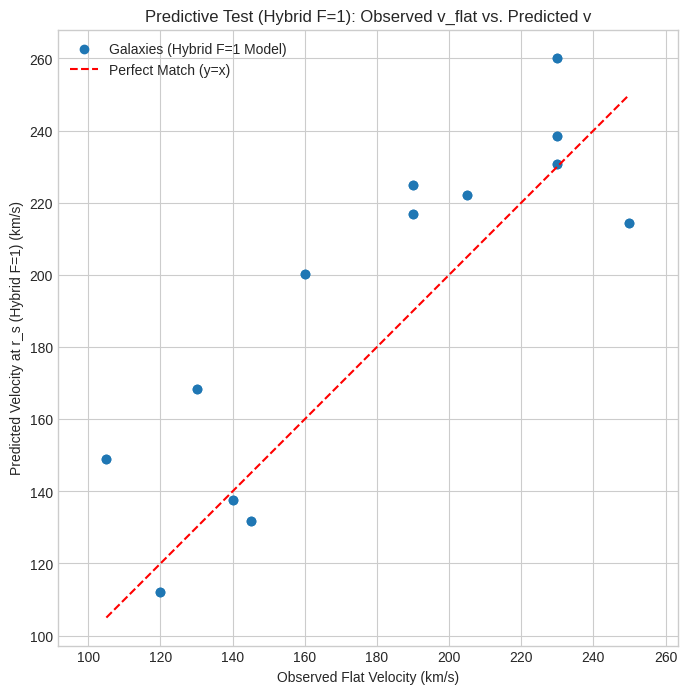

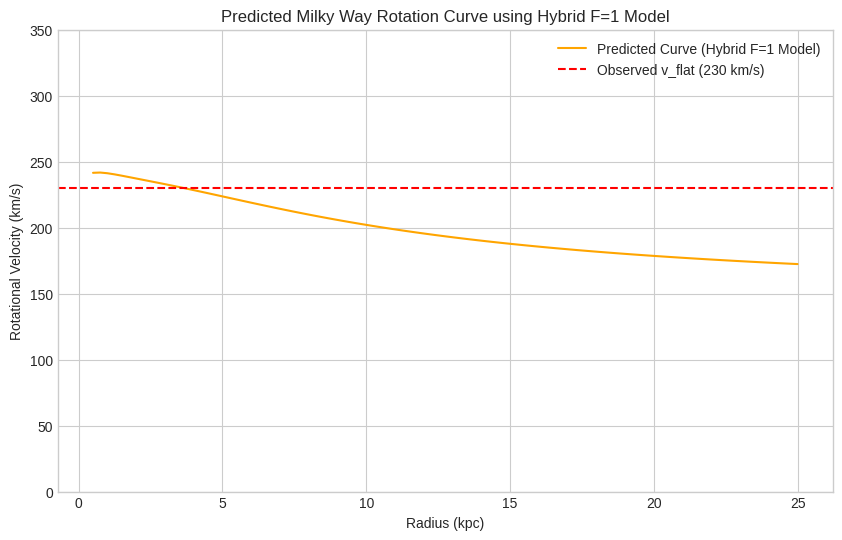

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19 # meters per kpc

# Parameters for the entropic coupling k'(M_b) sigmoid function
# As described in the paper explanation
L_coupling = 5.0e20  # kg/m (Max entanglement strength)
k_sigmoid = 1.5      # Dimensionless (Sigmoid sharpness)
x0_log_Msun = 40.8 - np.log10(M_SUN) # x0 in log10(Solar Mass units)

# --- Galaxy Data Provided by User ---
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0),
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Helper Functions ---

def k_prime_sigmoid(M_b_total_solar_masses):
  """Calculates the entropic coupling k' using the sigmoid function."""
  if M_b_total_solar_masses <= 0: return 0
  log10_Mb_Msun = np.log10(M_b_total_solar_masses)
  denominator = 1 + np.exp(-k_sigmoid * (log10_Mb_Msun - x0_log_Msun))
  if denominator == 0: return L_coupling
  return L_coupling / denominator

def M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=3.5, bulge_fraction=0.25):
    """Approximates Baryonic Mass Profile (Bulge + Disk)."""
    M_b_total_kg = M_b_total_solar_masses * M_SUN
    M_bulge_total = M_b_total_kg * bulge_fraction
    M_disk_total = M_b_total_kg * (1 - bulge_fraction)
    r_bulge_kpc = 0.5 * r_disk_kpc if r_disk_kpc > 0 else 0.1
    if r_kpc <= 0: return 0
    M_bulge = M_bulge_total * (r_kpc**2) / (r_kpc + r_bulge_kpc)**2 if r_bulge_kpc > 0 else 0
    M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk_kpc)) if r_disk_kpc > 0 else M_disk_total
    enclosed_baryonic = max(0, M_bulge) + max(0, M_disk)
    return min(enclosed_baryonic, M_b_total_kg)

def predict_Ment0_hybrid_factor1(M_b_total_solar_masses, r_s_kpc):
    """Predicts M_ent_0 using M_ent_0 = 1 * k'(Mb) * r_s."""
    if r_s_kpc <= 0: return 0
    kp_sig = k_prime_sigmoid(M_b_total_solar_masses)
    r_s_m = r_s_kpc * KPC_TO_M
    # M_ent_0 = 1 * k'(Mb) * r_s
    predicted_Ment0 = 1.0 * kp_sig * r_s_m
    return predicted_Ment0

# --- Rotation Curve Calculation Function (Hybrid Model, Factor=1) ---

def calculate_rotation_velocity_hybrid_factor1(r_kpc, M_b_total_solar_masses, r_s_kpc):
    """Predicts rotation velocity using the hybrid M_ent model with factor=1."""
    if r_kpc <= 0 or r_s_kpc <= 0: return 0

    r_m = r_kpc * KPC_TO_M
    r_s_m = r_s_kpc * KPC_TO_M

    # 1. Predict M_ent_0 using the factor=1 hybrid approach
    predicted_Ment0 = predict_Ment0_hybrid_factor1(M_b_total_solar_masses, r_s_kpc)

    # 2. Calculate Baryonic Mass at radius r
    current_M_b = M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=r_s_kpc)

    # 3. Calculate Entanglement Mass using the r^3/(1+r^2) formula structure
    r_ratio = r_m / r_s_m
    if r_s_m == 0: M_ent = 0
    else:
        denominator = (1 + r_ratio**2)
        if denominator == 0: M_ent = 0
        else:
             M_ent = predicted_Ment0 * r_ratio * (r_ratio**2) / denominator

    # 4. Calculate Effective Mass
    M_eff = current_M_b + M_ent
    if M_eff < 0: M_eff = 0

    # 5. Calculate Rotational Velocity
    v_m_s = np.sqrt(G_N * M_eff / r_m)
    return v_m_s / 1000 # Convert to km/s

# --- Analysis Loop ---
print("\n--- Rotation Curve Prediction (Hybrid Factor=1 Model) ---")
# ADDED v_asymptote to the header
print(f"{'Galaxy':<17} | {'M_b (1e10 M_sun)':<18} | {'r_s (kpc)':<10} | {'v_flat (Obs km/s)':<18} | {'Calc. k_prime':<15} | {'v_asymptote (km/s)':<20} | {'Pred. v @ r_s (F=1)':<20} | {'Pred. v @ 20kpc (F=1)':<22}")
print("-" * 150) # Adjusted print width

for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    # Calculate k' based on TOTAL baryonic mass
    kp_val = k_prime_sigmoid(mb_msun)

    # --- ADD THIS SECTION ---
    # Calculate the predicted asymptotic velocity based only on k'
    v_asymptote_kms = 0.0
    if kp_val > 0:
        v_asymptote_ms = np.sqrt(G_N * kp_val)
        v_asymptote_kms = v_asymptote_ms / 1000
    # --- END OF ADDED SECTION ---

    # Predict velocity at scale radius r_s and at a larger radius (20 kpc) using the hybrid method
    predicted_v_at_rs = calculate_rotation_velocity_hybrid_factor1(rs_kpc, mb_msun, rs_kpc)
    predicted_v_at_20kpc = calculate_rotation_velocity_hybrid_factor1(20.0, mb_msun, rs_kpc)
    predicted_Ment0_val_hyb1 = predict_Ment0_hybrid_factor1(mb_msun, rs_kpc) # Predicted M_ent_0

    # Store results (optional, can add v_asymptote if needed later)
    hybrid_factor1_results.append({
        "Galaxy": name,
        "v_flat_obs": vflat_kms,
        "Predicted_v_at_rs": predicted_v_at_rs,
        "Predicted_v_at_20kpc": predicted_v_at_20kpc
        # "v_asymptote_kms": v_asymptote_kms # Add if you want to store it
    })

    # Updated print statement to include the new column
    print(f"{name:<17} | {mb_msun/1e10:<18.2f} | {rs_kpc:<10.1f} | {vflat_kms:<18.1f} | {kp_val:<15.3e} | {v_asymptote_kms:<20.1f} | {predicted_v_at_rs:<20.1f} | {predicted_v_at_20kpc:<22.1f}")


# --- Plotting Predicted (Hybrid F=1) vs Observed v_flat ---
pred_v_hybrid1_at_rs = np.array([res['Predicted_v_at_rs'] for res in hybrid_factor1_results])
obs_v_flat_hybrid1 = np.array([res['v_flat_obs'] for res in hybrid_factor1_results])

plt.figure(figsize=(8, 8))
plt.scatter(obs_v_flat_hybrid1, pred_v_hybrid1_at_rs, label='Galaxies (Hybrid F=1 Model)')
plt.plot([min(obs_v_flat_hybrid1), max(obs_v_flat_hybrid1)], [min(obs_v_flat_hybrid1), max(obs_v_flat_hybrid1)], 'r--', label='Perfect Match (y=x)')
plt.xlabel('Observed Flat Velocity (km/s)')
plt.ylabel('Predicted Velocity at r_s (Hybrid F=1) (km/s)')
plt.title('Predictive Test (Hybrid F=1): Observed v_flat vs. Predicted v')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Plot Example Predicted Rotation Curve (e.g., for Milky Way using Hybrid F=1 Model) ---
mw_data_hyb1 = next(item for item in galaxy_data if item[0] == "Milky Way")
mw_mb_msun_hyb1, mw_vflat_hyb1, mw_rs_kpc_hyb1 = mw_data_hyb1[1], mw_data_hyb1[2], mw_data_hyb1[3]

radii_plot_mw_hyb1 = np.linspace(0.5, 25, 100) # Radii for plotting MW curve
velocities_plot_mw_hyb1 = [calculate_rotation_velocity_hybrid_factor1(r, mw_mb_msun_hyb1, mw_rs_kpc_hyb1) for r in radii_plot_mw_hyb1]

plt.figure(figsize=(10, 6))
plt.plot(radii_plot_mw_hyb1, velocities_plot_mw_hyb1, 'orange', linestyle='-', label=f'Predicted Curve (Hybrid F=1 Model)')
plt.axhline(y=mw_vflat_hyb1, color='r', linestyle='--', label=f'Observed v_flat ({mw_vflat_hyb1} km/s)')

plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title(f'Predicted Milky Way Rotation Curve using Hybrid F=1 Model')
plt.legend()
plt.grid(True)
plt.ylim(0, 350) # Adjust y-axis if needed
plt.show()



--- Predicted Baryonic Tully-Fisher Relation (BTFR) Analysis ---
Using v_pred = v_asymptote = sqrt(G * k'(Mb))
Fit: log10(M_b) = slope * log10(v_pred) + intercept
Slope (x in M_b proportional to v^x): 6.033
Intercept: 9.999
R-squared: 0.993
(Observed BTFR slope is typically ~3.5-4.0)


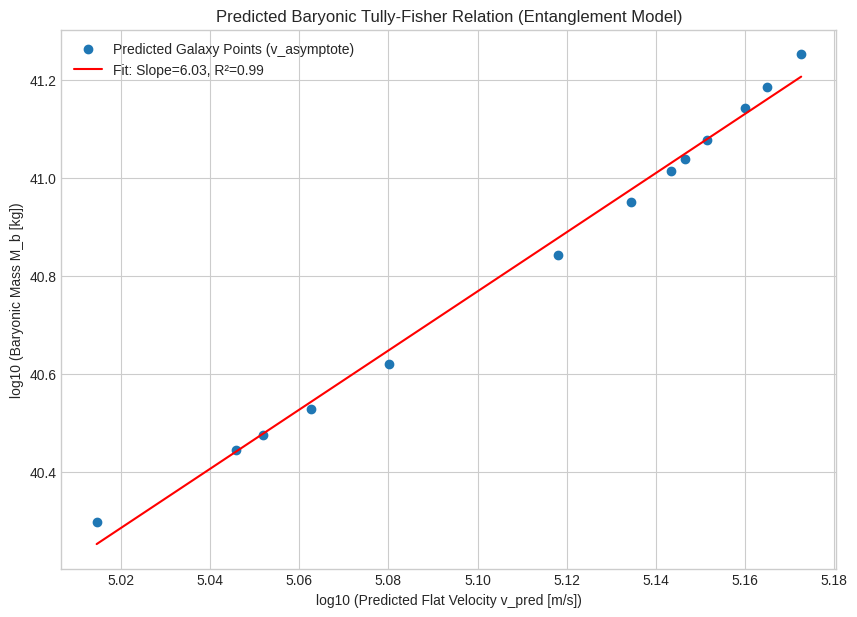

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress # For linear regression analysis

# --- Constants ---
G_N = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30  # kg (solar mass)
# KPC_TO_M = 3.0857e19 # meters per kpc - Not directly needed here

# Parameters for the entropic coupling k'(M_b) sigmoid function
# As described in the paper explanation
L_coupling = 5.0e20  # kg/m (Max entanglement strength)
k_sigmoid = 1.5      # Dimensionless (Sigmoid sharpness)
x0_log_Msun = 40.8 - np.log10(M_SUN) # x0 in log10(Solar Mass units)

# --- Galaxy Data Provided by User ---
# Format: (Galaxy Name, M_b [M_sun], v_flat [km/s], r_s [kpc])
# Note: v_flat and r_s are observed values, not used directly in this prediction test
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0),
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Helper Function ---
def k_prime_sigmoid(M_b_total_solar_masses):
  """Calculates the entropic coupling k' using the sigmoid function."""
  if M_b_total_solar_masses <= 0: return 0
  log10_Mb_Msun = np.log10(M_b_total_solar_masses)
  denominator = 1 + np.exp(-k_sigmoid * (log10_Mb_Msun - x0_log_Msun))
  if denominator == 0: return L_coupling
  return L_coupling / denominator

# --- Calculate Predicted Asymptotic Velocity for Each Galaxy ---
btfr_results = []
for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    M_b_kg = mb_msun * M_SUN
    kp_val = k_prime_sigmoid(mb_msun)
    v_asymptote_kms = 0.0
    if kp_val > 0:
        v_asymptote_ms = np.sqrt(G_N * kp_val)
        v_asymptote_kms = v_asymptote_ms / 1000

    if M_b_kg > 0 and v_asymptote_kms > 0:
        btfr_results.append({
            "Galaxy": name,
            "log_M_b": np.log10(M_b_kg),
            "log_v_pred": np.log10(v_asymptote_kms * 1000) # Use m/s for log
        })

# --- Perform BTFR Regression ---
log_M_b_btfr = np.array([res['log_M_b'] for res in btfr_results])
log_v_pred_btfr = np.array([res['log_v_pred'] for res in btfr_results])

# Fit: log(Mb) = slope * log(v_pred) + intercept
# (Standard BTFR plots M vs v, so we regress M on v)
slope, intercept, r_value, p_value, std_err = linregress(log_v_pred_btfr, log_M_b_btfr)

print("\n--- Predicted Baryonic Tully-Fisher Relation (BTFR) Analysis ---")
print("Using v_pred = v_asymptote = sqrt(G * k'(Mb))")
print(f"Fit: log10(M_b) = slope * log10(v_pred) + intercept")
print(f"Slope (x in M_b proportional to v^x): {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print("(Observed BTFR slope is typically ~3.5-4.0)")

# --- Plotting Predicted BTFR ---
plt.figure(figsize=(10, 7))
plt.scatter(log_v_pred_btfr, log_M_b_btfr, label='Predicted Galaxy Points (v_asymptote)')
# Plot the fit line
fit_log_v = np.linspace(min(log_v_pred_btfr), max(log_v_pred_btfr), 100)
fit_log_M = intercept + slope * fit_log_v
plt.plot(fit_log_v, fit_log_M, 'r-', label=f'Fit: Slope={slope:.2f}, R²={r_value**2:.2f}')

plt.ylabel('log10 (Baryonic Mass M_b [kg])')
plt.xlabel('log10 (Predicted Flat Velocity v_pred [m/s])')
plt.title('Predicted Baryonic Tully-Fisher Relation (Entanglement Model)')
plt.legend()
plt.grid(True)
plt.show()


--- Rotation Curve Prediction (Standard S_base = 2.60e+58 bits) ---
Galaxy            | M_b (1e10 M_sun)   | r_s (kpc)  | v_flat (Obs km/s)  | Pred. v @ r_s (S0)   | Pred. v @ 20kpc (S0)  
-------------------------------------------------------------------------------------------------------------------
Milky Way         | 6.00               | 3.5        | 230.0              | 207.7                | 111.2                 
NGC 2403          | 1.50               | 3.0        | 140.0              | 112.2                | 55.8                  
UGC 128           | 1.00               | 3.5        | 120.0              | 84.8                 | 45.4                  
Andromeda (M31)   | 7.70               | 5.5        | 250.0              | 187.7                | 123.7                 
NGC 3198          | 1.70               | 4.0        | 145.0              | 103.4                | 59.0                  
NGC 7331          | 9.00               | 4.0        | 230.0              | 238.0         

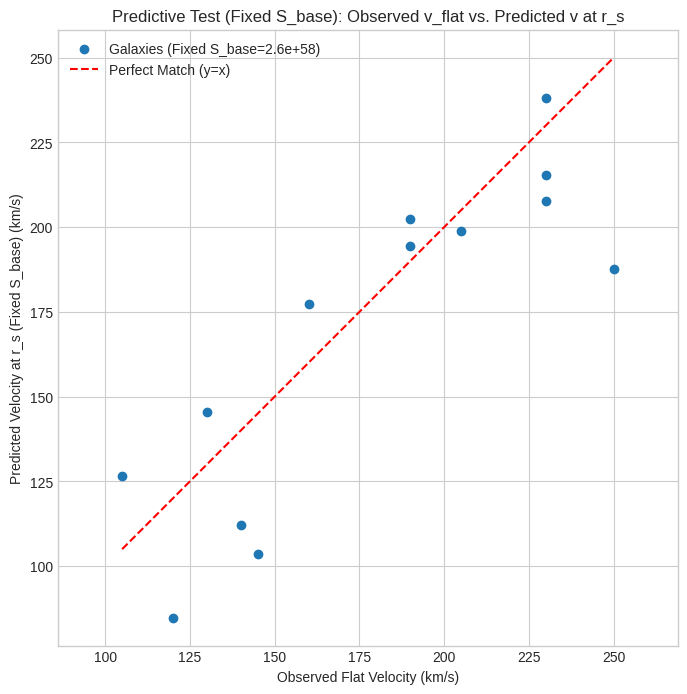

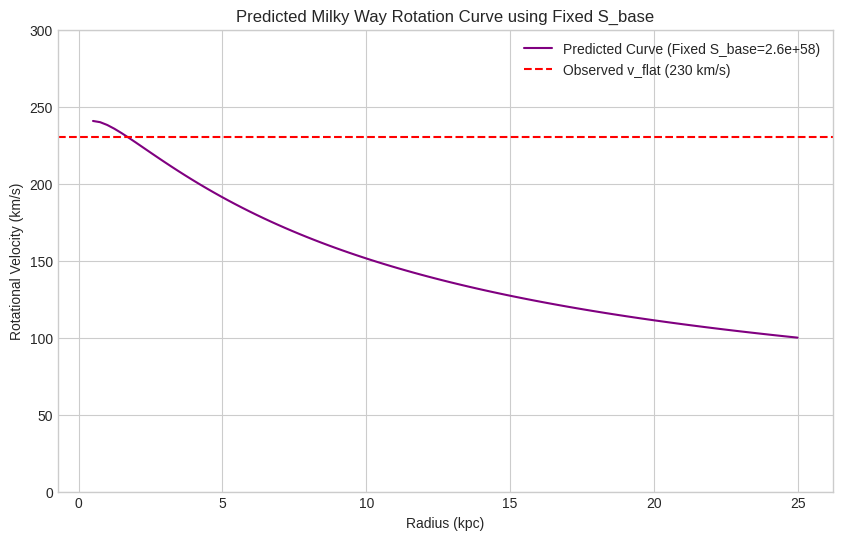

In [ ]:
# Import necessary libraries (run this in your local Python environment)
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G_N = 6.67430e-11      # Gravitational constant (m^3 kg^-1 s^-2)
M_SUN = 1.989e30      # kg (solar mass)
KPC_TO_M = 3.0857e19     # meters per kpc
C = 2.99792458e8      # m/s (Speed of light)
L_P = 1.616255e-35     # m (Planck length)
# K_MASS_ENTROPY = 2.14e-74 # kg/bit - Not directly used here

# Derived lambda coupling constant (vFinal PDF Appendix A.2.6)
LAMBDA_CONST = (C**2 * L_P**2) / (4 * np.pi * G_N) # ~2.75e-28 m^2

# --- Assumed Standard Galaxy S_base ---
# Using the value calculated for NGC 3198 in vFinal Appendix A.2.2 as a test case
S_BASE_STANDARD = 2.6e58 # bits (Hypothesized standard value for galaxies)

# --- Galaxy Data Provided by User ---
galaxy_data = [
    ("Milky Way", 6.0e10, 230, 3.5),
    ("NGC 2403", 1.5e10, 140, 3.0),
    ("UGC 128", 1.0e10, 120, 3.5),
    ("Andromeda (M31)", 7.7e10, 250, 5.5),
    ("NGC 3198", 1.7e10, 145, 4.0), # S_BASE_STANDARD was derived fitting this one
    ("NGC 7331", 9.0e10, 230, 4.0),
    ("NGC 5055", 5.5e10, 205, 3.5),
    ("NGC 6946", 3.5e10, 160, 2.8),
    ("NGC 2903", 4.5e10, 190, 3.0),
    ("NGC 3621", 2.1e10, 130, 2.5),
    ("NGC 2841", 7.0e10, 230, 3.8),
    ("NGC 3521", 5.2e10, 190, 3.2),
    ("NGC 925", 1.4e10, 105, 2.2)
]

# --- Helper Functions ---

def M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=3.5, bulge_fraction=0.25):
    """Approximates Baryonic Mass Profile (Bulge + Disk)."""
    M_b_total_kg = M_b_total_solar_masses * M_SUN
    M_bulge_total = M_b_total_kg * bulge_fraction
    M_disk_total = M_b_total_kg * (1 - bulge_fraction)
    r_bulge_kpc = 0.5 * r_disk_kpc if r_disk_kpc > 0 else 0.1
    if r_kpc <= 0: return 0
    M_bulge = M_bulge_total * (r_kpc**2) / (r_kpc + r_bulge_kpc)**2 if r_bulge_kpc > 0 else 0
    M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk_kpc)) if r_disk_kpc > 0 else M_disk_total
    enclosed_baryonic = max(0, M_bulge) + max(0, M_disk)
    return min(enclosed_baryonic, M_b_total_kg)

def calculate_Ment_S0_profile(r_m, r_s_m, S_base):
    """Calculates M_ent(r) from the logarithmic S_ent profile and lambda."""
    if r_m <= 0 or r_s_m <= 0 or S_base <= 0:
        return 0

    r_ratio = r_m / r_s_m
    # Ensure ln argument is > 0 (it will be since r_ratio >= 0)
    # Ensure denominator is not zero (1+r_ratio is > 0)
    term1 = np.log(1 + r_ratio) # Natural logarithm
    term2 = r_ratio / (1 + r_ratio)

    # M_ent(r) = (lambda * S_base / G_N) * [ln(1 + r/r_s) - (r/r_s)/(1 + r/r_s)]
    M_ent = (LAMBDA_CONST * S_base / G_N) * (term1 - term2)

    return max(0, M_ent) # Ensure non-negative mass

# --- Rotation Curve Calculation Function (Standard S_base) ---

def calculate_rotation_velocity_S0(r_kpc, M_b_total_solar_masses, r_s_kpc, S_base):
    """Predicts rotation velocity using M_ent derived from fixed S_base."""
    if r_kpc <= 0 or r_s_kpc <= 0: return 0

    r_m = r_kpc * KPC_TO_M
    r_s_m = r_s_kpc * KPC_TO_M

    # 1. Calculate Baryonic Mass at radius r
    current_M_b = M_b_galaxy_profile(r_kpc, M_b_total_solar_masses, r_disk_kpc=r_s_kpc)

    # 2. Calculate Entanglement Mass using the standard S_base
    M_ent = calculate_Ment_S0_profile(r_m, r_s_m, S_base)

    # 3. Calculate Effective Mass
    M_eff = current_M_b + M_ent

    # 4. Calculate Rotational Velocity
    v_m_s = np.sqrt(G_N * M_eff / r_m)
    return v_m_s / 1000 # Convert to km/s

# --- Analysis Loop ---
S0_results = []

print(f"\n--- Rotation Curve Prediction (Standard S_base = {S_BASE_STANDARD:.2e} bits) ---")
print(f"{'Galaxy':<17} | {'M_b (1e10 M_sun)':<18} | {'r_s (kpc)':<10} | {'v_flat (Obs km/s)':<18} | {'Pred. v @ r_s (S0)':<20} | {'Pred. v @ 20kpc (S0)':<22}")
print("-" * 115)

for name, mb_msun, vflat_kms, rs_kpc in galaxy_data:
    # Predict velocity at scale radius r_s and at a larger radius (20 kpc)
    predicted_v_at_rs = calculate_rotation_velocity_S0(rs_kpc, mb_msun, rs_kpc, S_BASE_STANDARD)
    predicted_v_at_20kpc = calculate_rotation_velocity_S0(20.0, mb_msun, rs_kpc, S_BASE_STANDARD)

    S0_results.append({
        "Galaxy": name,
        "v_flat_obs": vflat_kms,
        "Predicted_v_at_rs": predicted_v_at_rs,
        "Predicted_v_at_20kpc": predicted_v_at_20kpc
    })
    print(f"{name:<17} | {mb_msun/1e10:<18.2f} | {rs_kpc:<10.1f} | {vflat_kms:<18.1f} | {predicted_v_at_rs:<20.1f} | {predicted_v_at_20kpc:<22.1f}")


# --- Plotting Predicted (Standard S0) vs Observed v_flat ---
pred_v_S0_at_rs = np.array([res['Predicted_v_at_rs'] for res in S0_results])
obs_v_flat_S0 = np.array([res['v_flat_obs'] for res in S0_results])

plt.figure(figsize=(8, 8))
plt.scatter(obs_v_flat_S0, pred_v_S0_at_rs, label=f'Galaxies (Fixed S_base={S_BASE_STANDARD:.1e})')
plt.plot([min(obs_v_flat_S0), max(obs_v_flat_S0)], [min(obs_v_flat_S0), max(obs_v_flat_S0)], 'r--', label='Perfect Match (y=x)')
plt.xlabel('Observed Flat Velocity (km/s)')
plt.ylabel('Predicted Velocity at r_s (Fixed S_base) (km/s)')
plt.title('Predictive Test (Fixed S_base): Observed v_flat vs. Predicted v at r_s')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Plot Example Predicted Rotation Curve (e.g., for Milky Way using Fixed S_base) ---
mw_data_S0 = next(item for item in galaxy_data if item[0] == "Milky Way")
mw_mb_msun_S0, mw_vflat_S0, mw_rs_kpc_S0 = mw_data_S0[1], mw_data_S0[2], mw_data_S0[3]

radii_plot_mw_S0 = np.linspace(0.5, 25, 100) # Radii for plotting MW curve
velocities_plot_mw_S0 = [calculate_rotation_velocity_S0(r, mw_mb_msun_S0, mw_rs_kpc_S0, S_BASE_STANDARD) for r in radii_plot_mw_S0]

plt.figure(figsize=(10, 6))
plt.plot(radii_plot_mw_S0, velocities_plot_mw_S0, 'purple', linestyle='-', label=f'Predicted Curve (Fixed S_base={S_BASE_STANDARD:.1e})')
plt.axhline(y=mw_vflat_S0, color='r', linestyle='--', label=f'Observed v_flat ({mw_vflat_S0} km/s)')

plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title(f'Predicted Milky Way Rotation Curve using Fixed S_base')
plt.legend()
plt.grid(True)
plt.ylim(0, 300) # Adjust y-axis if needed
plt.show()


--- Testing Milky Way ---
Radius (kpc) | Predicted v (km/s) | Observed v (km/s) ± Error
        2.0 |             252.3 |        210.0 ± 28
        5.0 |             200.5 |        220.0 ± 15
        8.0 |             170.0 |        230.0 ± 10
       12.0 |             143.4 |        236.0 ± 20
       20.0 |             112.8 |        215.0 ± 25


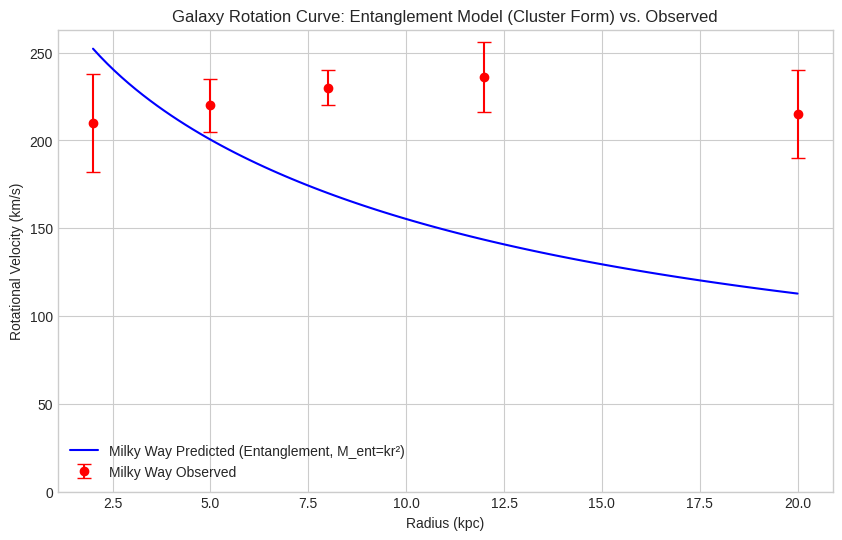

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
G = 6.67430e-11  # m^3 kg^-1 s^-2 (gravitational constant)
M_SUN = 1.989e30  # kg (solar mass)
KPC_TO_M = 3.0857e19  # meters per kpc

# --- Entanglement Model Parameters ---
# Using M_ent = k * r^2 form, k calibrated for v~220km/s at 10kpc
k = 1.3e-10  # kg/m^2

# --- Baryonic Mass Functions (kg) ---

def M_b_milky_way(r_kpc):
    """Approximate cumulative baryonic mass for Milky Way (Bulge + Disk)."""
    M_bulge_total = 1.5e10 * M_SUN
    M_disk_total = 4.5e10 * M_SUN
    r_bulge = 1.0  # kpc
    r_disk = 3.5  # kpc
    # Bulge: Hernquist-like profile M*(r/rb)/(1+r/rb) (simplified)
    M_bulge = M_bulge_total * (r_kpc / r_bulge) / (1 + r_kpc / r_bulge)
    # Disk: Exponential profile M*(1 - exp(-r/rd))
    M_disk = M_disk_total * (1 - np.exp(-r_kpc / r_disk))
    return M_bulge + M_disk

# --- Entanglement and Effective Mass ---

def M_ent(r_m):
    """Entanglement mass contribution (quadratic form from clusters/lensing)."""
    return k * r_m**2

def M_eff(r_kpc, M_b_func):
    """Effective mass (Baryonic + Entanglement)."""
    r_m = r_kpc * KPC_TO_M
    return M_b_func(r_kpc) + M_ent(r_m)

# --- Rotational Velocity ---

def v_rot(r_kpc, M_b_func):
    """Rotational velocity (km/s)."""
    r_m = r_kpc * KPC_TO_M
    if r_m == 0:
        return 0
    mass_eff = M_eff(r_kpc, M_b_func)
    if mass_eff < 0:
        return np.nan
    return np.sqrt(G * mass_eff / r_m) / 1000  # km/s

# --- Galaxy Data ---

galaxy_data = {
    "Milky Way": {
        "M_b_func": M_b_milky_way,
        "radii_kpc": np.array([2, 5, 8, 12, 20]),
        "observed_v_kms": np.array([210, 220, 230, 236, 215]),
        "errors_kms": np.array([28, 15, 10, 20, 25])
    }
    # Can add NGC 3198 data here if needed
}

# --- Test and Plot ---

plt.figure(figsize=(10, 6))

for name, data in galaxy_data.items():
    print(f"\n--- Testing {name} ---")
    print("Radius (kpc) | Predicted v (km/s) | Observed v (km/s) ± Error")

    pred_v_kms = []
    # Key radii for table
    radii_key = data["radii_kpc"]
    velocities_key = [v_rot(r, data["M_b_func"]) for r in radii_key]

    for r, v_pred, v_obs, err in zip(radii_key, velocities_key, data["observed_v_kms"], data["errors_kms"]):
        print(f"{r:11.1f} | {v_pred:17.1f} | {v_obs:12.1f} ± {err}")

    # Plotting
    plt.errorbar(data["radii_kpc"], data["observed_v_kms"], yerr=data["errors_kms"],
                 fmt='ro', label=f'{name} Observed', capsize=5)
    # Plot predicted curve using a finer radius grid for smoothness
    r_fine = np.linspace(min(data["radii_kpc"]), max(data["radii_kpc"]), 100)
    if min(r_fine) <= 0: # Avoid r=0 if present
        r_fine = np.linspace(0.1, max(data["radii_kpc"]), 100)
    v_fine = [v_rot(r, data["M_b_func"]) for r in r_fine]
    plt.plot(r_fine, v_fine, 'b-', label=f'{name} Predicted (Entanglement, M_ent=kr²)')

plt.xlabel('Radius (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.title('Galaxy Rotation Curve: Entanglement Model (Cluster Form) vs. Observed')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Ensure velocity doesn't go below zero
plt.show()


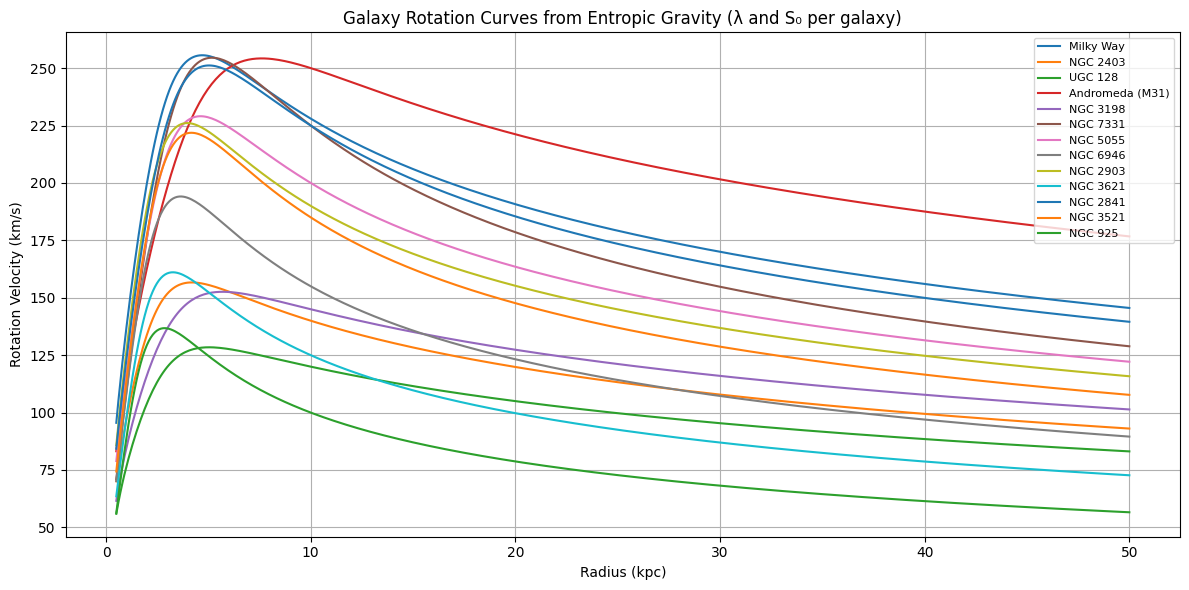

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11        # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19    # conversion: kiloparsecs to meters
S_ent_total = 1e57     # universal suppressed entanglement bits per galaxy
r_fit_kpc = 10         # reference radius for lambda calibration (kpc)
r_fit = r_fit_kpc * kpc_to_m

# ----------------------------
# Galaxy Data
# ----------------------------
galaxy_names = [
    "Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198", "NGC 7331",
    "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621", "NGC 2841", "NGC 3521", "NGC 925"
]

# Masses in solar masses → convert to kg
M_bulge = np.array([1.0e10, 0.2e10, 0.1e10, 2.0e10, 0.3e10, 3.0e10,
                    1.2e10, 0.8e10, 1.5e10, 0.1e10, 2.5e10, 1.6e10, 0.1e10]) * 1.989e30
M_disk  = np.array([5.0e10, 1.3e10, 0.9e10, 5.7e10, 1.4e10, 6.0e10,
                    4.3e10, 2.7e10, 3.0e10, 2.0e10, 4.5e10, 3.6e10, 1.3e10]) * 1.989e30
M_vals = M_bulge + M_disk

# Disk scale radii in kpc → convert to meters
r_disk_kpc = np.array([3.5, 3.0, 3.5, 5.5, 4.0, 4.0, 3.5, 2.8, 3.0, 2.5, 3.8, 3.2, 2.2])
r_disk_m = r_disk_kpc * kpc_to_m
rs_m_vals = r_disk_m
halo_radius_m = 5 * r_disk_m

# Observed velocities at ~10 kpc (km/s) → convert to m/s
v_obs_profiles_kms = [
    [216.5, 230, 228, 220, 215], [140, 140, 140], [120, 120, 120], [250, 250, 250], [145, 145, 145],
    [180, 210, 225, 230, 230], [160, 185, 200, 205, 205], [90, 135, 155, 160], [130, 170, 190, 190],
    [75, 110, 125, 130], [180, 215, 225, 230], [145, 175, 185, 190], [65, 90, 100, 105]
]
v_obs_fit_m_s = np.array([v[len(v)//2] for v in v_obs_profiles_kms]) * 1000

# ----------------------------
# Functions
# ----------------------------
def M_profile(r, M_total, r_s):
    """Smoothed baryonic mass profile (inner rising to outer flat)"""
    return M_total * (r**3 / (r**3 + r_s**3))

def S0_from_structure(r_halo, r_s):
    """S0 value per galaxy to match S_ent_total given structure"""
    return S_ent_total / np.log(1 + r_halo / r_s)

def bracket_function(r, r_s):
    """Entropy profile shape function"""
    return np.log(1 + r / r_s) - r / (r + r_s)

# ----------------------------
# Compute S0 and Lambda per Galaxy
# ----------------------------
S0_vals = S0_from_structure(halo_radius_m, rs_m_vals)
M_r_fit = M_profile(r_fit, M_vals, rs_m_vals)
bracket_at_r_fit = bracket_function(r_fit, rs_m_vals)
v2_obs = v_obs_fit_m_s**2

lambda_vals = (v2_obs - G * M_r_fit / r_fit) * r_fit / (G * S0_vals * bracket_at_r_fit)

# ----------------------------
# Plot Rotation Curves
# ----------------------------
r_range_kpc = np.linspace(0.5, 50, 500)
r_range_m = r_range_kpc * kpc_to_m

plt.figure(figsize=(12, 6))

for i in range(len(galaxy_names)):
    M = M_vals[i]
    S0 = S0_vals[i]
    lam = lambda_vals[i]
    rs = rs_m_vals[i]

    M_r = M_profile(r_range_m, M, rs)
    ent_term = G * lam * S0 * bracket_function(r_range_m, rs) / r_range_m
    v2_total = G * M_r / r_range_m + ent_term
    v_model_kms = np.sqrt(v2_total) / 1000

    plt.plot(r_range_kpc, v_model_kms, label=galaxy_names[i])

plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
plt.title("Galaxy Rotation Curves from Entropic Gravity (λ and S₀ per galaxy)")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


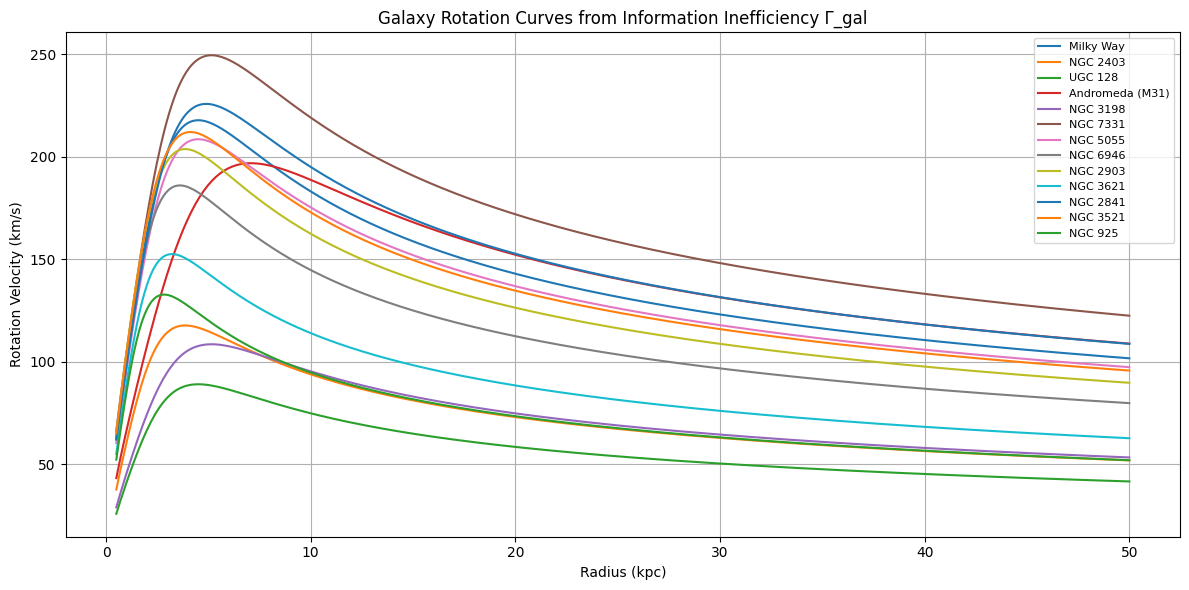

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11        # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19    # kiloparsec to meters
S_ent_total = 1e57     # total suppressed vacuum entanglement per galaxy (bits)

# ----------------------------
# Galaxy Data
# ----------------------------
galaxy_names = [
    "Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198", "NGC 7331",
    "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621", "NGC 2841", "NGC 3521", "NGC 925"
]

# Convert baryonic mass (solar mass) to kg
M_bulge = np.array([1.0e10, 0.2e10, 0.1e10, 2.0e10, 0.3e10, 3.0e10,
                    1.2e10, 0.8e10, 1.5e10, 0.1e10, 2.5e10, 1.6e10, 0.1e10]) * 1.989e30
M_disk  = np.array([5.0e10, 1.3e10, 0.9e10, 5.7e10, 1.4e10, 6.0e10,
                    4.3e10, 2.7e10, 3.0e10, 2.0e10, 4.5e10, 3.6e10, 1.3e10]) * 1.989e30
M_vals = M_bulge + M_disk  # total baryonic mass (kg)

# Disk scale radii (r_s) in kpc → meters
r_disk_kpc = np.array([3.5, 3.0, 3.5, 5.5, 4.0, 4.0, 3.5, 2.8, 3.0, 2.5, 3.8, 3.2, 2.2])
rs_m_vals = r_disk_kpc * kpc_to_m
halo_radius_m = 5 * rs_m_vals  # assumed halo extent

# ----------------------------
# Functions
# ----------------------------
def M_profile(r, M_total, r_s):
    """Baryonic mass distribution profile"""
    return M_total * (r**3 / (r**3 + r_s**3))

def S0_from_structure(r_halo, r_s):
    """Calculate S0 such that S_ent_total = S0 * ln(1 + R / r_s)"""
    return S_ent_total / np.log(1 + r_halo / r_s)

def bracket_function(r, r_s):
    return np.log(1 + r / r_s) - r / (r + r_s)

# ----------------------------
# Setup radius range
# ----------------------------
r_range_kpc = np.linspace(0.5, 50, 500)
r_range_m = r_range_kpc * kpc_to_m

# ----------------------------
# Plot rotation curves using Γ_gal = M / S_ent_total
# ----------------------------
plt.figure(figsize=(12, 6))

for i in range(len(galaxy_names)):
    M = M_vals[i]
    rs = rs_m_vals[i]
    r_halo = halo_radius_m[i]

    # Information inefficiency (kg per bit)
    Gamma_gal = M / S_ent_total

    # Field amplitude S0 from structure
    S0 = S0_from_structure(r_halo, rs)

    # Compute baryonic and entanglement mass profiles
    M_r = M_profile(r_range_m, M, rs)
    ent_mass = Gamma_gal * S0 * bracket_function(r_range_m, rs)

    # Compute rotation velocity
    v2_total = G * (M_r + ent_mass) / r_range_m
    v_model_kms = np.sqrt(v2_total) / 1000  # convert to km/s

    plt.plot(r_range_kpc, v_model_kms, label=galaxy_names[i])

plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
plt.title("Galaxy Rotation Curves from Information Inefficiency Γ_gal")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


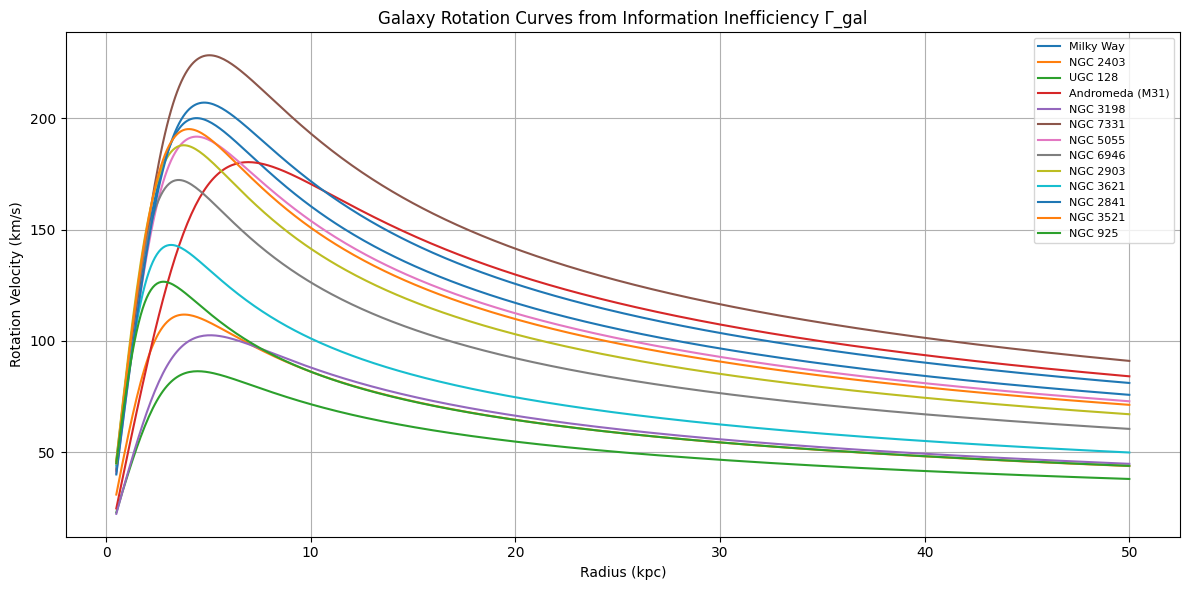

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11        # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19    # kiloparsec to meters
S_ent_total = 1e57     # total suppressed vacuum entanglement per galaxy (bits)

# ----------------------------
# Galaxy Data
# ----------------------------
galaxy_names = [
    "Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198", "NGC 7331",
    "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621", "NGC 2841", "NGC 3521", "NGC 925"
]

# Convert baryonic mass (solar mass) to kg
M_bulge = np.array([1.0e10, 0.2e10, 0.1e10, 2.0e10, 0.3e10, 3.0e10,
                    1.2e10, 0.8e10, 1.5e10, 0.1e10, 2.5e10, 1.6e10, 0.1e10]) * 1.989e30
M_disk  = np.array([5.0e10, 1.3e10, 0.9e10, 5.7e10, 1.4e10, 6.0e10,
                    4.3e10, 2.7e10, 3.0e10, 2.0e10, 4.5e10, 3.6e10, 1.3e10]) * 1.989e30
M_vals = M_bulge + M_disk  # total baryonic mass (kg)

# Disk scale radii (r_s) in kpc → meters
r_disk_kpc = np.array([3.5, 3.0, 3.5, 5.5, 4.0, 4.0, 3.5, 2.8, 3.0, 2.5, 3.8, 3.2, 2.2])
rs_m_vals = r_disk_kpc * kpc_to_m
halo_radius_m = 5 * rs_m_vals  # assumed halo extent

# ----------------------------
# Functions
# ----------------------------
def M_profile(r, M_total, r_s):
    """Baryonic mass distribution profile"""
    return M_total * (r**3 / (r**3 + r_s**3))

def S0_from_structure(r_halo, r_s):
    """Calculate S0 such that S_ent_total = S0 * ln(1 + R / r_s)"""
    return S_ent_total / np.log(1 + r_halo / r_s)

def bracket_function(r, r_s):
    return np.log(1 + r / r_s) - r / (r + r_s)

# ----------------------------
# Setup radius range
# ----------------------------
r_range_kpc = np.linspace(0.5, 50, 500)
r_range_m = r_range_kpc * kpc_to_m

# ----------------------------
# Plot rotation curves using Γ_gal = M / S_ent_total
# ----------------------------
plt.figure(figsize=(12, 6))

for i in range(len(galaxy_names)):
    M = M_vals[i]
    rs = rs_m_vals[i]
    r_halo = halo_radius_m[i]

    # Information inefficiency (kg per bit)
    Gamma_gal = M / S_ent_total

    # Field amplitude S0 from structure
    S0 = S0_from_structure(r_halo, rs)

    # Compute baryonic and entanglement mass profiles
    M_r = M_profile(r_range_m, M, rs)
    lambda_vFinal = 9.14e-28  # m^2
    ent_mass = (lambda_vFinal * S0 / G) * bracket_function(r_range_m, rs)

    # Compute rotation velocity
    v2_total = G * (M_r + ent_mass) / r_range_m
    v_model_kms = np.sqrt(v2_total) / 1000  # convert to km/s

    plt.plot(r_range_kpc, v_model_kms, label=galaxy_names[i])

plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
plt.title("Galaxy Rotation Curves from Information Inefficiency Γ_gal")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:

import numpy as np
# Removed matplotlib import as plotting is not supported here

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11      # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19  # conversion: kiloparsecs to meters
S_ent_total = 1e57   # ASSUMED total suppressed vacuum entanglement per galaxy (bits) - Used to calculate S0
# *** Using Universal Gamma_gal constant ***
# Value chosen based on previous discussion (numerical similarity to fitted lambda)
# Units are kg/bit, treated numerically here.
Gamma_gal_universal = 5e-16
epsilon = 1e-15      # Small number to prevent division by zero / log issues near zero
M_sun_kg = 1.989e30 # Solar mass kg conversion fix

# ----------------------------
# Galaxy Data
# ----------------------------
galaxy_names = [
    "Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198", "NGC 7331",
    "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621", "NGC 2841", "NGC 3521", "NGC 925"
]

# Masses in solar masses → convert to kg
M_bulge = np.array([1.0e10, 0.2e10, 0.1e10, 2.0e10, 0.3e10, 3.0e10,
                    1.2e10, 0.8e10, 1.5e10, 0.1e10, 2.5e10, 1.6e10, 0.1e10]) * M_sun_kg
M_disk  = np.array([5.0e10, 1.3e10, 0.9e10, 5.7e10, 1.4e10, 6.0e10,
                    4.3e10, 2.7e10, 3.0e10, 2.0e10, 4.5e10, 3.6e10, 1.3e10]) * M_sun_kg
M_vals = M_bulge + M_disk  # total baryonic mass (kg)

# Disk scale radii (r_s) in kpc → meters
r_disk_kpc = np.array([3.5, 3.0, 3.5, 5.5, 4.0, 4.0, 3.5, 2.8, 3.0, 2.5, 3.8, 3.2, 2.2])
rs_m_vals = r_disk_kpc * kpc_to_m # Assume saturation scale rs = disk scale length
halo_radius_m = 5 * rs_m_vals   # assumed halo extent

# Store observed radii/velocities for comparison printout
v_obs_profiles_data = {
    "Milky Way": ([2, 5, 8, 12, 20], [216.5, 230, 228, 220, 215]),
    "NGC 2403": ([2, 6, 10], [140, 140, 140]),
    "UGC 128": ([2, 6, 10], [120, 120, 120]),
    "Andromeda (M31)": ([5, 12, 20], [250, 250, 250]),
    "NGC 3198": ([5, 10, 15], [145, 145, 145]),
    "NGC 7331": ([3, 6, 9, 12, 18], [180, 210, 225, 230, 230]),
    "NGC 5055": ([2, 5, 8, 12, 20], [160, 185, 200, 205, 205]),
    "NGC 6946": ([1, 4, 8, 12], [90, 135, 155, 160]),
    "NGC 2903": ([2, 5, 10, 15], [130, 170, 190, 190]),
    "NGC 3621": ([1, 3, 6, 10], [75, 110, 125, 130]),
    "NGC 2841": ([2, 6, 10, 16], [180, 215, 225, 230]),
    "NGC 3521": ([2, 6, 10, 14], [145, 175, 185, 190]),
    "NGC 925": ([1, 3, 6, 9], [65, 90, 100, 105])
}

# ----------------------------
# Functions
# ----------------------------
def M_profile(r, M_total, r_s):
    """Baryonic mass distribution profile"""
    # Ensure r and r_s are treated as arrays for element-wise operations
    r_arr = np.asarray(r)
    r_s_arr = np.asarray(r_s)
    r_safe = np.maximum(r_arr, epsilon)
    r_s_safe = np.maximum(r_s_arr, epsilon)
    # Ensure M_total broadcasts correctly if r is an array and M_total is scalar for the galaxy
    M_total_arr = np.asarray(M_total)
    power_term = r_safe**3 + r_s_safe**3
    # Use np.divide for safe division, though denominators should be positive
    ratio_cubed = np.divide(r_safe**3, power_term, out=np.zeros_like(r_safe), where=power_term!=0)
    return M_total_arr * ratio_cubed

def S0_from_structure(r_halo, r_s):
    """Calculate S0 such that S_ent_total = S0 * ln(1 + r_halo / r_s)"""
    r_s_safe = np.maximum(r_s, epsilon)
    r_halo_safe = np.maximum(r_halo, epsilon)
    ratio = r_halo_safe / r_s_safe
    # Use np.log1p for potentially better precision for small ratios (log(1+x))
    log_val = np.log1p(ratio) # log1p handles ratio > -1 safely
    # Use np.where for conditional calculation to avoid division by zero
    S0_result = np.where(np.abs(log_val) > epsilon, S_ent_total / log_val, np.inf)
    return S0_result

def bracket_function(r, r_s):
    """Entropy profile shape function. Vectorized implementation."""
    # Ensure inputs are arrays and safe
    r_arr = np.asarray(r)
    r_s_arr = np.asarray(r_s) # Ensure r_s is treated as array if needed
    r_safe = np.maximum(r_arr, epsilon)
    r_s_safe = np.maximum(r_s_arr, epsilon)

    # Calculate log term safely
    log_arg = r_safe / r_s_safe # Argument for log1p is x where we want log(1+x)
    log_term = np.log1p(log_arg) # Use log1p, safe for positive args

    # Calculate ratio term safely
    denominator = r_safe + r_s_safe
    # Use np.divide with 'where' clause for safe division
    ratio_term = np.divide(r_safe, denominator, out=np.zeros_like(r_safe), where=denominator!=0)

    return log_term - ratio_term

# ----------------------------
# Calculate and Print Results
# ----------------------------
print("Rotation Curve Predictions using Universal Gamma_gal")
print(f"Using: G={G:.3e}, Universal Gamma_gal={Gamma_gal_universal:.1e} kg/bit, Assumed S_ent_total={S_ent_total:.1e} bits")
print("-" * 70)
print(f"{'Galaxy':<15} | {'rs (kpc)':<8} | {'S0 (bits)':<10} | {'Radius (kpc)':<12} | {'Vpred (km/s)':<12}")
print("-" * 70)

# Use a representative radius range for printing, e.g., first and last observed points
for i in range(len(galaxy_names)):
    name = galaxy_names[i]
    M = M_vals[i]
    rs = rs_m_vals[i]
    r_halo = halo_radius_m[i]

    # Field amplitude S0 calculated from structure and S_ent_total
    S0 = S0_from_structure(r_halo, rs)

    # Get radii for printing
    obs_radii_kpc, obs_vels_kms = v_obs_profiles_data[name]
    radii_to_print_kpc = [obs_radii_kpc[0], obs_radii_kpc[-1]]
    radii_to_print_m = np.array(radii_to_print_kpc) * kpc_to_m

    # Print galaxy info
    print(f"{name:<15} | {rs/kpc_to_m:<8.1f} | {S0:>.2e} |", end="") # Print first part

    # Check if S0 is valid before proceeding
    if not np.isfinite(S0):
        print(f"{' ': <12} | {'NaN':<12}")
        print(f"{' ':<15} | {' ':<8} | {' ':<10} | {' ': <12} | {' ':<12}  (Invalid S0)")
        continue

    # Compute baryonic mass profile at specific radii
    # Ensure M_profile handles scalar M and rs correctly when r is an array
    M_r = M_profile(radii_to_print_m, M, rs)

    # Compute entanglement mass using UNIVERSAL Gamma_gal at specific radii
    # Ensure bracket_function handles scalar rs correctly when r is an array
    bracket = bracket_function(radii_to_print_m, rs)
    ent_mass = Gamma_gal_universal * S0 * bracket

    # Compute rotation velocity safely at specific radii
    v2_baryon = np.divide(G * M_r, radii_to_print_m, out=np.zeros_like(radii_to_print_m), where=radii_to_print_m!=0)
    v2_ent = np.divide(G * ent_mass, radii_to_print_m, out=np.zeros_like(radii_to_print_m), where=radii_to_print_m!=0)
    v2_total = v2_baryon + v2_ent

    # Ensure v2_total is not negative before sqrt
    v2_total_safe = np.maximum(v2_total, 0)
    v_model_kms = np.sqrt(v2_total_safe) / 1000  # convert to km/s

    # Print results for the two radii
    print(f" {radii_to_print_kpc[0]:<12.1f} | {v_model_kms[0]:<12.1f}")
    print(f"{' ':<15} | {' ':<8} | {' ':<10} | {radii_to_print_kpc[1]:<12.1f} | {v_model_kms[1]:<12.1f}")


print("-" * 70)


Rotation Curve Predictions using Universal Gamma_gal
Using: G=6.674e-11, Universal Gamma_gal=5.0e-16 kg/bit, Assumed S_ent_total=1.0e+57 bits
----------------------------------------------------------------------
Galaxy          | rs (kpc) | S0 (bits)  | Radius (kpc) | Vpred (km/s)
----------------------------------------------------------------------
Milky Way       | 3.5      | 5.58e+56 | 2.0          | 216.7       
                |          |            | 20.0         | 211.2       
NGC 2403        | 3.0      | 5.58e+56 | 2.0          | 202.0       
                |          |            | 10.0         | 219.9       
UGC 128         | 3.5      | 5.58e+56 | 2.0          | 173.3       
                |          |            | 10.0         | 202.2       
Andromeda (M31) | 5.5      | 5.58e+56 | 5.0          | 221.3       
                |          |            | 20.0         | 197.1       
NGC 3198        | 4.0      | 5.58e+56 | 5.0          | 201.2       
                |         

Using Universal Gamma_gal = 5.00e-16 (kg/bit implied units)


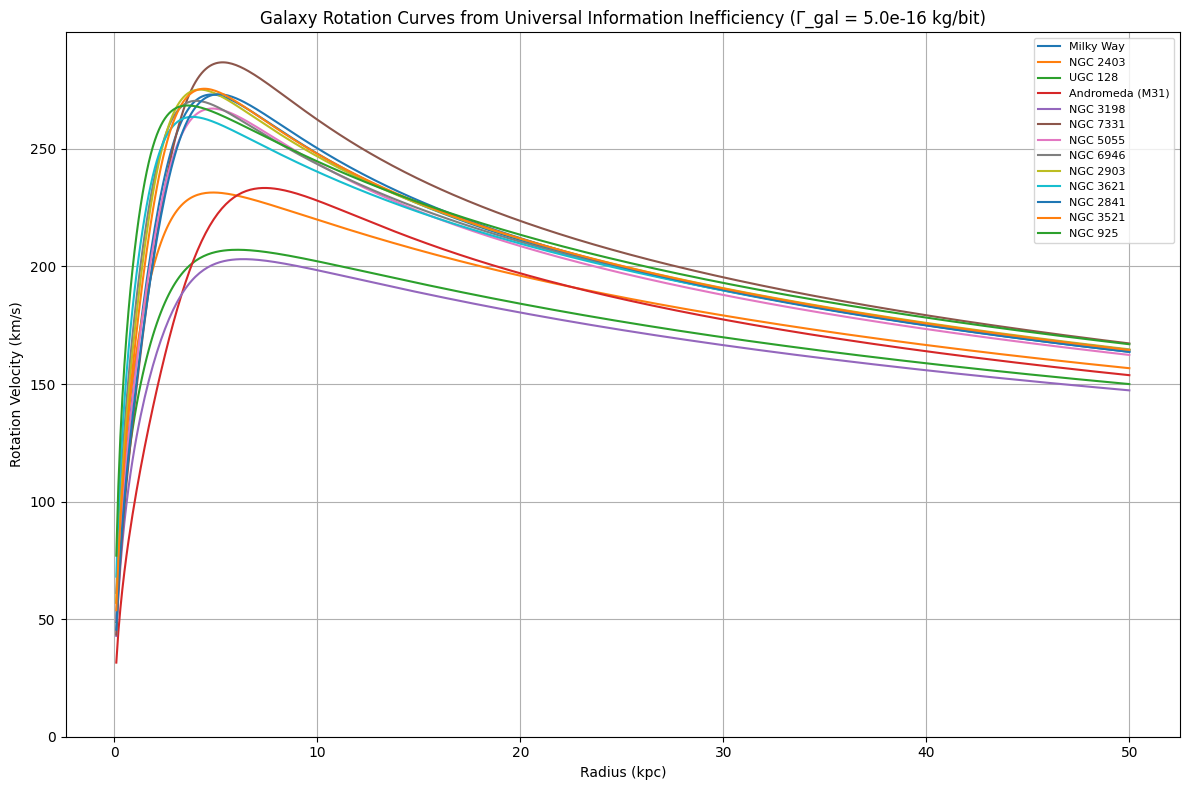


Code execution complete. Plot generation attempted.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt # Re-import matplotlib

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11      # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19  # conversion: kiloparsecs to meters
S_ent_total = 1e57   # ASSUMED total suppressed vacuum entanglement per galaxy (bits) - Used to calculate S0
# *** Using Universal Gamma_gal constant ***
# Value chosen based on previous discussion (numerical similarity to fitted lambda)
# Units are kg/bit, treated numerically here.
Gamma_gal_universal = 5e-16
epsilon = 1e-15      # Small number to prevent division by zero / log issues near zero
M_sun_kg = 1.989e30 # Solar mass kg conversion fix

# ----------------------------
# Galaxy Data
# ----------------------------
galaxy_names = [
    "Milky Way", "NGC 2403", "UGC 128", "Andromeda (M31)", "NGC 3198", "NGC 7331",
    "NGC 5055", "NGC 6946", "NGC 2903", "NGC 3621", "NGC 2841", "NGC 3521", "NGC 925"
]

# Masses in solar masses → convert to kg
M_bulge = np.array([1.0e10, 0.2e10, 0.1e10, 2.0e10, 0.3e10, 3.0e10,
                    1.2e10, 0.8e10, 1.5e10, 0.1e10, 2.5e10, 1.6e10, 0.1e10]) * M_sun_kg
M_disk  = np.array([5.0e10, 1.3e10, 0.9e10, 5.7e10, 1.4e10, 6.0e10,
                    4.3e10, 2.7e10, 3.0e10, 2.0e10, 4.5e10, 3.6e10, 1.3e10]) * M_sun_kg
M_vals = M_bulge + M_disk  # total baryonic mass (kg)

# Disk scale radii (r_s) in kpc → meters
r_disk_kpc = np.array([3.5, 3.0, 3.5, 5.5, 4.0, 4.0, 3.5, 2.8, 3.0, 2.5, 3.8, 3.2, 2.2])
rs_m_vals = r_disk_kpc * kpc_to_m # Assume saturation scale rs = disk scale length
halo_radius_m = 5 * rs_m_vals   # assumed halo extent

# ----------------------------
# Functions
# ----------------------------
def M_profile(r, M_total, r_s):
    """Baryonic mass distribution profile"""
    # Ensure r and r_s are treated as arrays for element-wise operations
    r_arr = np.asarray(r)
    r_s_arr = np.asarray(r_s)
    r_safe = np.maximum(r_arr, epsilon)
    r_s_safe = np.maximum(r_s_arr, epsilon)
    # Ensure M_total broadcasts correctly if r is an array and M_total is scalar for the galaxy
    M_total_arr = np.asarray(M_total)
    power_term = r_safe**3 + r_s_safe**3
    # Use np.divide for safe division, although denominators should be positive
    ratio_cubed = np.divide(r_safe**3, power_term, out=np.zeros_like(r_safe), where=power_term!=0)
    return M_total_arr * ratio_cubed

def S0_from_structure(r_halo, r_s):
    """Calculate S0 such that S_ent_total = S0 * ln(1 + r_halo / r_s)"""
    r_s_safe = np.maximum(r_s, epsilon)
    r_halo_safe = np.maximum(r_halo, epsilon)
    ratio = r_halo_safe / r_s_safe
    # Use np.log1p for potentially better precision for small ratios (log(1+x))
    log_val = np.log1p(ratio) # log1p handles ratio > -1 safely
    # Use np.where for conditional calculation to avoid division by zero
    S0_result = np.where(np.abs(log_val) > epsilon, S_ent_total / log_val, np.inf)
    return S0_result

def bracket_function(r, r_s):
    """Entropy profile shape function. Vectorized implementation."""
    # Ensure inputs are arrays and safe
    r_arr = np.asarray(r)
    r_s_arr = np.asarray(r_s) # Ensure r_s is treated as array if needed
    r_safe = np.maximum(r_arr, epsilon)
    r_s_safe = np.maximum(r_s_arr, epsilon)

    # Calculate log term safely
    log_arg = r_safe / r_s_safe # Argument for log1p is x where we want log(1+x)
    log_term = np.log1p(log_arg) # Use log1p, safe for positive args

    # Calculate ratio term safely
    denominator = r_safe + r_s_safe
    # Use np.divide with 'where' clause for safe division
    ratio_term = np.divide(r_safe, denominator, out=np.zeros_like(r_safe), where=denominator!=0)

    return log_term - ratio_term

# ----------------------------
# Setup radius range for plotting
# ----------------------------
r_range_kpc = np.linspace(0.1, 50, 500) # Start slightly away from 0
r_range_m = r_range_kpc * kpc_to_m

# ----------------------------
# Plot rotation curves using UNIVERSAL Gamma_gal
# ----------------------------
print(f"Using Universal Gamma_gal = {Gamma_gal_universal:.2e} (kg/bit implied units)")
# Initialize the plot
plt.figure(figsize=(12, 8)) # Increased figure size slightly

for i in range(len(galaxy_names)):
    M = M_vals[i]
    rs = rs_m_vals[i]
    r_halo = halo_radius_m[i]

    # Field amplitude S0 calculated from structure and S_ent_total
    S0 = S0_from_structure(r_halo, rs)

    # Check if S0 is valid before proceeding
    if not np.isfinite(S0):
        print(f"Skipping {galaxy_names[i]} due to invalid S0 calculation.")
        continue

    # Compute baryonic mass profile over the radius range
    # Ensure M_profile handles scalar M and rs with array r_range_m
    M_r = M_profile(r_range_m, M, rs)

    # Compute entanglement mass using UNIVERSAL Gamma_gal over the radius range
    # Ensure bracket_function handles scalar rs with array r_range_m
    bracket = bracket_function(r_range_m, rs)
    ent_mass = Gamma_gal_universal * S0 * bracket

    # Compute rotation velocity safely over the radius range
    v2_baryon = np.divide(G * M_r, r_range_m, out=np.zeros_like(r_range_m), where=r_range_m!=0)
    v2_ent = np.divide(G * ent_mass, r_range_m, out=np.zeros_like(r_range_m), where=r_range_m!=0)
    v2_total = v2_baryon + v2_ent

    # Ensure v2_total is not negative before sqrt
    v2_total_safe = np.maximum(v2_total, 0)
    v_model_kms = np.sqrt(v2_total_safe) / 1000  # convert to km/s

    # Add this galaxy's curve to the plot
    plt.plot(r_range_kpc, v_model_kms, label=galaxy_names[i])

# Finalize and show plot
plt.xlabel("Radius (kpc)")
plt.ylabel("Rotation Velocity (km/s)")
# Updated title to reflect the use of universal Gamma_gal
plt.title(f"Galaxy Rotation Curves from Universal Information Inefficiency (Γ_gal = {Gamma_gal_universal:.1e} kg/bit)")
plt.grid(True)
plt.legend(fontsize=8, loc='upper right') # Adjusted legend location
plt.ylim(bottom=0) # Ensure y-axis starts at 0
plt.tight_layout()
plt.show()

print("\nCode execution complete. Plot generation attempted.")


In [ ]:
import numpy as np

# ----------------------------
# Constants
# ----------------------------
G = 6.67430e-11      # gravitational constant (m^3 kg^-1 s^-2)
kpc_to_m = 3.086e19  # conversion: kiloparsecs to meters
M_sun_kg = 1.989e30 # Solar mass kg conversion fix
epsilon = 1e-15      # Small number to prevent division by zero / log issues near zero

# *** Using Universal Gamma_gal constant ***
# Value chosen based on previous discussion (numerical similarity to fitted lambda)
# Units are kg/bit, treated numerically here.
Gamma_gal_universal = 5e-16
print(f"Using Universal Gamma_gal = {Gamma_gal_universal:.1e} kg/bit (implied units)")

# ----------------------------
# Cluster Parameters (Example)
# ----------------------------
# Typical Baryonic Mass for a cluster (e.g., Coma cluster ~1-2e14 M_sun total mass, baryons ~10-15%)
M_cluster_total = 1.5e13 * M_sun_kg # Example: 1.5e13 M_sun in baryons

# Structural scales for clusters (larger than galaxies)
# rs ~ core radius, r_halo ~ virial radius estimate
rs_cluster_kpc = 200.0 # Cluster core radius (kpc) - based on user previous input
rs_cluster_m = rs_cluster_kpc * kpc_to_m

# Estimate halo extent (e.g., 5-10 times core radius)
r_halo_cluster_m = 5 * rs_cluster_m # Assumed extent for S0 calculation

# Assumed Total Suppressed Entanglement for Clusters (from user summary)
S_ent_total_cluster = 2e60 # bits (larger than galaxy's 1e57)

print(f"\nCluster Parameters:")
print(f"  M_b_total = {M_cluster_total:.2e} kg")
print(f"  rs = {rs_cluster_kpc:.1f} kpc = {rs_cluster_m:.2e} m")
print(f"  r_halo (est.) = {r_halo_cluster_m/kpc_to_m:.1f} kpc = {r_halo_cluster_m:.2e} m")
print(f"  S_ent_total (assumed) = {S_ent_total_cluster:.1e} bits")

# ----------------------------
# Functions (Identical to before)
# ----------------------------
def M_profile(r, M_total, r_s):
    """Baryonic mass distribution profile"""
    r_safe = np.maximum(np.asarray(r), epsilon)
    r_s_safe = np.maximum(np.asarray(r_s), epsilon)
    M_total_arr = np.asarray(M_total)
    power_term = r_safe**3 + r_s_safe**3
    ratio_cubed = np.divide(r_safe**3, power_term, out=np.zeros_like(r_safe), where=power_term!=0)
    return M_total_arr * ratio_cubed

def S0_from_structure(S_ent_total_sys, r_halo, r_s):
    """Calculate S0 such that S_ent_total_sys = S0 * ln(1 + r_halo / r_s)"""
    r_s_safe = np.maximum(r_s, epsilon)
    r_halo_safe = np.maximum(r_halo, epsilon)
    ratio = r_halo_safe / r_s_safe
    log_val = np.log1p(ratio) # log1p handles ratio > -1 safely
    S0_result = np.where(np.abs(log_val) > epsilon, S_ent_total_sys / log_val, np.inf)
    return S0_result

def bracket_function(r, r_s):
    """Entropy profile shape function. Vectorized implementation."""
    r_arr = np.asarray(r)
    r_s_arr = np.asarray(r_s) # Ensure r_s is treated as array if needed
    r_safe = np.maximum(r_arr, epsilon)
    r_s_safe = np.maximum(r_s_arr, epsilon)
    log_arg = r_safe / r_s_safe # Argument for log1p is x where we want log(1+x)
    log_term = np.log1p(log_arg) # Use log1p, safe for positive args
    denominator = r_safe + r_s_safe
    ratio_term = np.divide(r_safe, denominator, out=np.zeros_like(r_safe), where=denominator!=0)
    return log_term - ratio_term

# ----------------------------
# Calculation for Cluster
# ----------------------------
# Calculate Cluster S0
S0_cluster = S0_from_structure(S_ent_total_cluster, r_halo_cluster_m, rs_cluster_m)
print(f"  Calculated S0_cluster = {S0_cluster:.2e} bits")

# Radius range for cluster scale
r_range_kpc = np.linspace(50, 1500, 100) # kpc range for clusters
r_range_m = r_range_kpc * kpc_to_m

if not np.isfinite(S0_cluster):
    print("\nCannot calculate velocities due to invalid S0.")
else:
    # Compute baryonic mass profile
    M_r = M_profile(r_range_m, M_cluster_total, rs_cluster_m)

    # Compute entanglement mass using UNIVERSAL Gamma_gal
    bracket = bracket_function(r_range_m, rs_cluster_m)
    ent_mass = Gamma_gal_universal * S0_cluster * bracket

    # Compute characteristic velocity (dispersion proxy) safely
    v2_baryon = np.divide(G * M_r, r_range_m, out=np.zeros_like(r_range_m), where=r_range_m > epsilon)
    v2_ent = np.divide(G * ent_mass, r_range_m, out=np.zeros_like(r_range_m), where=r_range_m > epsilon)
    v2_total = v2_baryon + v2_ent

    v2_total_safe = np.maximum(v2_total, 0)
    v_model_kms = np.sqrt(v2_total_safe) / 1000  # convert to km/s

    # --- Print Sample Results ---
    print("\nPredicted Cluster Characteristic Velocity (Dispersion Proxy):")
    print("-" * 40)
    print(f"{'Radius (kpc)':<15} | {'Vpred (km/s)':<15}")
    print("-" * 40)
    # Print first, middle, and last points as samples
    indices_to_print = [0, len(r_range_kpc)//2, -1]
    for idx in indices_to_print:
        print(f"{r_range_kpc[idx]:<15.1f} | {v_model_kms[idx]:<15.1f}")
    print("-" * 40)

Using Universal Gamma_gal = 5.0e-16 kg/bit (implied units)

Cluster Parameters:
  M_b_total = 2.98e+43 kg
  rs = 200.0 kpc = 6.17e+21 m
  r_halo (est.) = 1000.0 kpc = 3.09e+22 m
  S_ent_total (assumed) = 2.0e+60 bits
  Calculated S0_cluster = 1.12e+60 bits

Predicted Cluster Characteristic Velocity (Dispersion Proxy):
----------------------------------------
Radius (kpc)    | Vpred (km/s)   
----------------------------------------
50.0            | 760.6          
782.3           | 1143.7         
1500.0          | 1027.1         
----------------------------------------


In [ ]:
import numpy as np

# Constants
G = 6.67430e-11       # m^3 kg^-1 s^-2
hbar = 1.054571817e-34  # J·s
c = 299792458         # m/s
ln2 = np.log(2)

# Black hole mass
M_bh = 1e41  # kg

# Black hole entropy in bits: S = 4π G M^2 / (ħ c ln 2)
S_bh_bits = (4 * np.pi * G * M_bh**2) / (hbar * c * ln2)
S_bh_bits

np.float64(3.827306675587622e+98)